# 模型微调（fine-tune)-迁移学习
- torchvision微调
- timm微调
- 半精度训练

起源：

- 1、随着深度学习的发展，模型的参数越来越大，许多开源模型都是在较大数据集上进行训练的，比如Imagenet-1k，Imagenet-11k等
- 2、如果数据集可能只有几千张，训练几千万参数的大模型，过拟合无法避免
- 3、如果我们想从零开始训练一个大模型，那么我们的解决办法是收集更多的数据。然而，收集和标注数据会花费大量的时间和资⾦，成本无法承受

解决方案：

- 应用迁移学习(transfer learning)，将从源数据集学到的知识迁移到目标数据集上
- 比如：ImageNet数据集的图像大多跟椅子无关，但在该数据集上训练的模型可以抽取较通用的图像特征，从而能够帮助识别边缘、纹理、形状和物体组成
- 模型微调（finetune）:就是先找到一个同类的别人训练好的模型，基于已经训练好的模型换成自己的数据，通过训练调整一下参数

#### 不同数据集下使用微调：

- 数据集1 - 数据量少，但数据相似度非常高 - 在这种情况下，我们所做的只是修改最后几层或最终的softmax图层的输出类别。

- 数据集2 - 数据量少，数据相似度低 - 在这种情况下，我们可以冻结预训练模型的初始层（比如k层），并再次训练剩余的（n-k）层。由于新数据集的相似度较低，因此根据新数据集对较高层进行重新训练具有重要意义。

- 数据集3 - 数据量大，数据相似度低 - 在这种情况下，由于我们有一个大的数据集，我们的神经网络训练将会很有效。但是，由于我们的数据与用于训练我们的预训练模型的数据相比有很大不同。使用预训练模型进行的预测不会有效。因此，最好根据你的数据从头开始训练神经网络（Training from scatch）

- 数据集4 - 数据量大，数据相似度高 - 这是理想情况。在这种情况下，预训练模型应该是最有效的。使用模型的最好方法是保留模型的体系结构和模型的初始权重。然后，我们可以使用在预先训练的模型中的权重来重新训练该模型。

#### 微调的是什么？
- 换数据源
- 针对K层进行重新训练
- K层的权重&shape调整

## 1、模型微调(fine-tune)一般流程：
- 1、在源数据集(如ImageNet数据集)上预训练一个神经网络模型，即源模型
- 2、创建一个新的神经网络模型，即目标模型，它复制了源模型上除了输出层外的所有模型设计及其参数
- 3、为目标模型添加一个输出⼤小为⽬标数据集类别个数的输出层，并随机初始化该层的模型参数
- 4、在目标数据集上训练目标模型。我们将从头训练输出层，而其余层的参数都是基于源模型的参数微调得到的

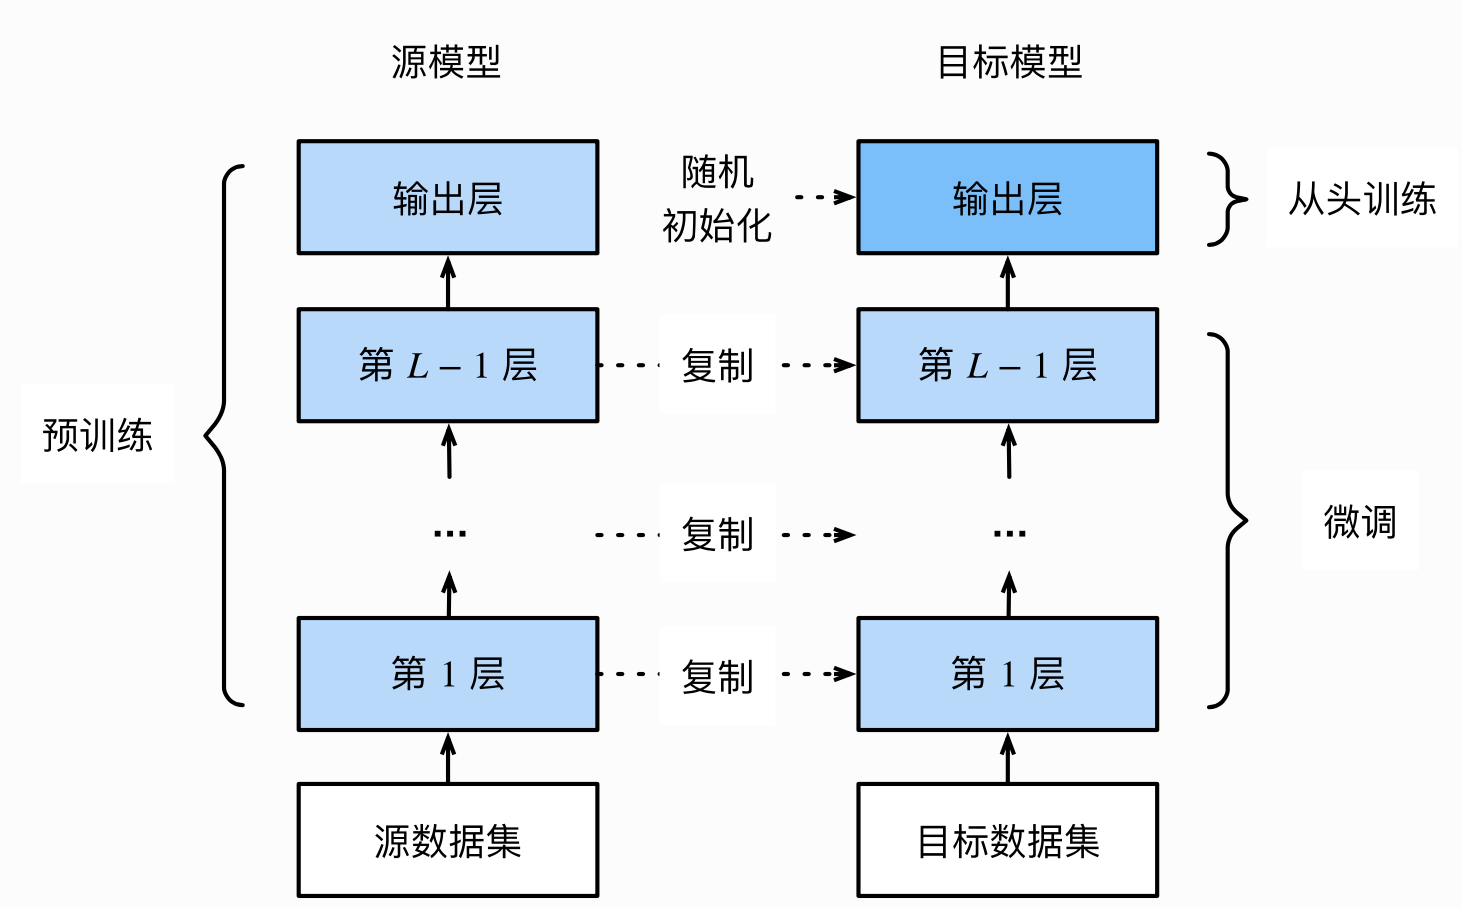

## 2、torchvision微调
### 2.1 实例化Model

```python
import torchvision.models as models
resnet34 = models.resnet34(pretrained=True)
```

pretrained参数说明：
- 1、通过True或者False来决定是否使用预训练好的权重，在默认状态下pretrained = False，意味着我们不使用预训练得到的权重
- 2、当pretrained = True，意味着我们将使用在一些数据集上预训练得到的权重

注意：如果中途强行停止下载的话，一定要去对应路径下将权重文件删除干净，否则会报错。

### 2.2 训练特定层
如果我们正在提取特征并且只想为新初始化的层计算梯度，其他参数不进行改变。那我们就需要通过设置requires_grad = False来冻结部分层

```python
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
```

### 2.3 实例
- 使用resnet34为例的将1000类改为10类，但是仅改变最后一层的模型参数
- 我们先冻结模型参数的梯度，再对模型输出部分的全连接层进行修改



In [33]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.optim.lr_scheduler import LambdaLR
from torch.optim.lr_scheduler import StepLR
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import torchvision.models as models
from torchinfo import summary

In [7]:
#超参数定义
# 批次的大小
batch_size = 16 #可选32、64、128
# 优化器的学习率
lr = 1e-4
#运行epoch
max_epochs = 2
# 方案二：使用“device”，后续对要使用GPU的变量用.to(device)即可
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu") 

In [8]:
# 数据读取
#cifar10数据集为例给出构建Dataset类的方式
from torchvision import datasets

#“data_transform”可以对图像进行一定的变换，如翻转、裁剪、归一化等操作，可自己定义
data_transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                   ])


train_cifar_dataset = datasets.CIFAR10('cifar10',train=True, download=False,transform=data_transform)
test_cifar_dataset = datasets.CIFAR10('cifar10',train=False, download=False,transform=data_transform)

#构建好Dataset后，就可以使用DataLoader来按批次读入数据了
train_loader = torch.utils.data.DataLoader(train_cifar_dataset, 
                                           batch_size=batch_size, num_workers=4, 
                                           shuffle=True, drop_last=True)

test_loader = torch.utils.data.DataLoader(test_cifar_dataset, 
                                         batch_size=batch_size, num_workers=4, 
                                         shuffle=False)



In [36]:
# 下载预训练模型 restnet34
resnet34 = models.resnet34(pretrained=True)
print(resnet34)

D:\Users\xulele\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Users\xulele\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\xulele/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:10<00:00, 8.57MB/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [37]:
#查看模型结构
summary(resnet34, (1, 3, 224, 224)) 

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

In [23]:
#检测 模型准确率
def cal_predict_correct(model):
    test_total_correct = 0
    for iter,(images,labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
    
        outputs = model(images)
        test_total_correct += (outputs.argmax(1) == labels).sum().item()
#     print("test_total_correct: "+ str(test_total_correct))
    return test_total_correct

In [63]:
total_correct = cal_predict_correct(resnet34)
print("test_total_correct: "+ str(test_total_correct / 10000))

test_total_correct: 0.1


In [39]:
#微调模型 resnet34
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            

# 冻结参数的梯度
feature_extract = True
new_model = resnet34
set_parameter_requires_grad(new_model, feature_extract)

# 修改模型
#训练过程中，model仍会进行梯度回传，但是参数更新则只会发生在fc层
num_ftrs = new_model.fc.in_features
new_model.fc = nn.Linear(in_features=num_ftrs, out_features=10, bias=True)



In [40]:
summary(new_model, (1, 3, 224, 224)) 

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 10]                   --
├─Conv2d: 1-1                            [1, 64, 112, 112]         (9,408)
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         (128)
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           (36,864)
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           (128)
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           (36,864)
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           (128)
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]   

In [41]:
#训练&验证
Resnet34_new = new_model.to(device)
# 定义损失函数和优化器
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# 损失函数：自定义损失函数
criterion = nn.CrossEntropyLoss()
# 优化器
optimizer = torch.optim.Adam(Resnet50_new.parameters(), lr=lr)
epoch = max_epochs

total_step = len(train_loader)
train_all_loss = []
test_all_loss = []

for i in range(epoch):
    Resnet34_new.train()
    train_total_loss = 0
    train_total_num = 0
    train_total_correct = 0

    for iter, (images,labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = Resnet34_new(images)
        loss = criterion(outputs,labels)
        train_total_correct += (outputs.argmax(1) == labels).sum().item()
        
        #backword
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_total_num += labels.shape[0]
        train_total_loss += loss.item()
        print("Epoch [{}/{}], Iter [{}/{}], train_loss:{:4f}".format(i+1,epoch,iter+1,total_step,loss.item()/labels.shape[0]))
    
    Resnet34_new.eval()
    test_total_loss = 0
    test_total_correct = 0
    test_total_num = 0
    for iter,(images,labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = Resnet34_new(images)
        loss = criterion(outputs,labels)
        test_total_correct += (outputs.argmax(1) == labels).sum().item()
        test_total_loss += loss.item()
        test_total_num += labels.shape[0]
    print("Epoch [{}/{}], train_loss:{:.4f}, train_acc:{:.4f}%, test_loss:{:.4f}, test_acc:{:.4f}%".format(
        i+1, epoch, train_total_loss / train_total_num, train_total_correct / train_total_num * 100, test_total_loss / test_total_num, test_total_correct / test_total_num * 100
    
    ))
    train_all_loss.append(np.round(train_total_loss / train_total_num,4))
    test_all_loss.append(np.round(test_total_loss / test_total_num,4))


Epoch [1/2], Iter [1/3125], train_loss:0.150127
Epoch [1/2], Iter [2/3125], train_loss:0.174470
Epoch [1/2], Iter [3/3125], train_loss:0.165727
Epoch [1/2], Iter [4/3125], train_loss:0.174811
Epoch [1/2], Iter [5/3125], train_loss:0.158658
Epoch [1/2], Iter [6/3125], train_loss:0.153260
Epoch [1/2], Iter [7/3125], train_loss:0.164495
Epoch [1/2], Iter [8/3125], train_loss:0.164485
Epoch [1/2], Iter [9/3125], train_loss:0.157202
Epoch [1/2], Iter [10/3125], train_loss:0.149555
Epoch [1/2], Iter [11/3125], train_loss:0.172609
Epoch [1/2], Iter [12/3125], train_loss:0.180861
Epoch [1/2], Iter [13/3125], train_loss:0.156719
Epoch [1/2], Iter [14/3125], train_loss:0.172375
Epoch [1/2], Iter [15/3125], train_loss:0.169886
Epoch [1/2], Iter [16/3125], train_loss:0.148726
Epoch [1/2], Iter [17/3125], train_loss:0.160391
Epoch [1/2], Iter [18/3125], train_loss:0.160285
Epoch [1/2], Iter [19/3125], train_loss:0.167672
Epoch [1/2], Iter [20/3125], train_loss:0.151213
Epoch [1/2], Iter [21/3125], 

Epoch [1/2], Iter [171/3125], train_loss:0.182332
Epoch [1/2], Iter [172/3125], train_loss:0.159162
Epoch [1/2], Iter [173/3125], train_loss:0.173818
Epoch [1/2], Iter [174/3125], train_loss:0.151095
Epoch [1/2], Iter [175/3125], train_loss:0.169016
Epoch [1/2], Iter [176/3125], train_loss:0.168345
Epoch [1/2], Iter [177/3125], train_loss:0.171198
Epoch [1/2], Iter [178/3125], train_loss:0.158377
Epoch [1/2], Iter [179/3125], train_loss:0.150349
Epoch [1/2], Iter [180/3125], train_loss:0.154732
Epoch [1/2], Iter [181/3125], train_loss:0.159255
Epoch [1/2], Iter [182/3125], train_loss:0.180752
Epoch [1/2], Iter [183/3125], train_loss:0.130398
Epoch [1/2], Iter [184/3125], train_loss:0.149835
Epoch [1/2], Iter [185/3125], train_loss:0.163545
Epoch [1/2], Iter [186/3125], train_loss:0.165769
Epoch [1/2], Iter [187/3125], train_loss:0.165499
Epoch [1/2], Iter [188/3125], train_loss:0.191183
Epoch [1/2], Iter [189/3125], train_loss:0.165406
Epoch [1/2], Iter [190/3125], train_loss:0.158130


Epoch [1/2], Iter [335/3125], train_loss:0.169697
Epoch [1/2], Iter [336/3125], train_loss:0.155575
Epoch [1/2], Iter [337/3125], train_loss:0.158214
Epoch [1/2], Iter [338/3125], train_loss:0.174536
Epoch [1/2], Iter [339/3125], train_loss:0.139395
Epoch [1/2], Iter [340/3125], train_loss:0.163447
Epoch [1/2], Iter [341/3125], train_loss:0.146871
Epoch [1/2], Iter [342/3125], train_loss:0.160089
Epoch [1/2], Iter [343/3125], train_loss:0.161521
Epoch [1/2], Iter [344/3125], train_loss:0.148263
Epoch [1/2], Iter [345/3125], train_loss:0.156887
Epoch [1/2], Iter [346/3125], train_loss:0.163093
Epoch [1/2], Iter [347/3125], train_loss:0.130156
Epoch [1/2], Iter [348/3125], train_loss:0.153562
Epoch [1/2], Iter [349/3125], train_loss:0.183320
Epoch [1/2], Iter [350/3125], train_loss:0.151159
Epoch [1/2], Iter [351/3125], train_loss:0.144421
Epoch [1/2], Iter [352/3125], train_loss:0.145968
Epoch [1/2], Iter [353/3125], train_loss:0.150598
Epoch [1/2], Iter [354/3125], train_loss:0.163271


Epoch [1/2], Iter [501/3125], train_loss:0.149830
Epoch [1/2], Iter [502/3125], train_loss:0.186489
Epoch [1/2], Iter [503/3125], train_loss:0.145313
Epoch [1/2], Iter [504/3125], train_loss:0.152114
Epoch [1/2], Iter [505/3125], train_loss:0.150460
Epoch [1/2], Iter [506/3125], train_loss:0.172033
Epoch [1/2], Iter [507/3125], train_loss:0.156441
Epoch [1/2], Iter [508/3125], train_loss:0.151387
Epoch [1/2], Iter [509/3125], train_loss:0.174799
Epoch [1/2], Iter [510/3125], train_loss:0.156212
Epoch [1/2], Iter [511/3125], train_loss:0.157743
Epoch [1/2], Iter [512/3125], train_loss:0.171979
Epoch [1/2], Iter [513/3125], train_loss:0.183507
Epoch [1/2], Iter [514/3125], train_loss:0.174797
Epoch [1/2], Iter [515/3125], train_loss:0.151998
Epoch [1/2], Iter [516/3125], train_loss:0.164528
Epoch [1/2], Iter [517/3125], train_loss:0.164061
Epoch [1/2], Iter [518/3125], train_loss:0.184687
Epoch [1/2], Iter [519/3125], train_loss:0.153723
Epoch [1/2], Iter [520/3125], train_loss:0.140085


Epoch [1/2], Iter [668/3125], train_loss:0.161691
Epoch [1/2], Iter [669/3125], train_loss:0.164216
Epoch [1/2], Iter [670/3125], train_loss:0.153614
Epoch [1/2], Iter [671/3125], train_loss:0.176628
Epoch [1/2], Iter [672/3125], train_loss:0.170113
Epoch [1/2], Iter [673/3125], train_loss:0.164020
Epoch [1/2], Iter [674/3125], train_loss:0.170262
Epoch [1/2], Iter [675/3125], train_loss:0.160252
Epoch [1/2], Iter [676/3125], train_loss:0.159595
Epoch [1/2], Iter [677/3125], train_loss:0.174482
Epoch [1/2], Iter [678/3125], train_loss:0.174136
Epoch [1/2], Iter [679/3125], train_loss:0.169684
Epoch [1/2], Iter [680/3125], train_loss:0.156718
Epoch [1/2], Iter [681/3125], train_loss:0.172149
Epoch [1/2], Iter [682/3125], train_loss:0.153396
Epoch [1/2], Iter [683/3125], train_loss:0.152438
Epoch [1/2], Iter [684/3125], train_loss:0.175598
Epoch [1/2], Iter [685/3125], train_loss:0.144732
Epoch [1/2], Iter [686/3125], train_loss:0.146447
Epoch [1/2], Iter [687/3125], train_loss:0.149588


Epoch [1/2], Iter [834/3125], train_loss:0.157354
Epoch [1/2], Iter [835/3125], train_loss:0.120264
Epoch [1/2], Iter [836/3125], train_loss:0.148319
Epoch [1/2], Iter [837/3125], train_loss:0.156353
Epoch [1/2], Iter [838/3125], train_loss:0.153210
Epoch [1/2], Iter [839/3125], train_loss:0.169396
Epoch [1/2], Iter [840/3125], train_loss:0.163863
Epoch [1/2], Iter [841/3125], train_loss:0.156365
Epoch [1/2], Iter [842/3125], train_loss:0.166741
Epoch [1/2], Iter [843/3125], train_loss:0.153688
Epoch [1/2], Iter [844/3125], train_loss:0.173625
Epoch [1/2], Iter [845/3125], train_loss:0.167021
Epoch [1/2], Iter [846/3125], train_loss:0.149013
Epoch [1/2], Iter [847/3125], train_loss:0.165667
Epoch [1/2], Iter [848/3125], train_loss:0.153663
Epoch [1/2], Iter [849/3125], train_loss:0.179361
Epoch [1/2], Iter [850/3125], train_loss:0.175290
Epoch [1/2], Iter [851/3125], train_loss:0.168034
Epoch [1/2], Iter [852/3125], train_loss:0.161994
Epoch [1/2], Iter [853/3125], train_loss:0.171823


Epoch [1/2], Iter [1000/3125], train_loss:0.174953
Epoch [1/2], Iter [1001/3125], train_loss:0.171201
Epoch [1/2], Iter [1002/3125], train_loss:0.157745
Epoch [1/2], Iter [1003/3125], train_loss:0.165321
Epoch [1/2], Iter [1004/3125], train_loss:0.166191
Epoch [1/2], Iter [1005/3125], train_loss:0.161590
Epoch [1/2], Iter [1006/3125], train_loss:0.155218
Epoch [1/2], Iter [1007/3125], train_loss:0.161306
Epoch [1/2], Iter [1008/3125], train_loss:0.160885
Epoch [1/2], Iter [1009/3125], train_loss:0.150420
Epoch [1/2], Iter [1010/3125], train_loss:0.180716
Epoch [1/2], Iter [1011/3125], train_loss:0.170864
Epoch [1/2], Iter [1012/3125], train_loss:0.155604
Epoch [1/2], Iter [1013/3125], train_loss:0.138882
Epoch [1/2], Iter [1014/3125], train_loss:0.163906
Epoch [1/2], Iter [1015/3125], train_loss:0.157286
Epoch [1/2], Iter [1016/3125], train_loss:0.176689
Epoch [1/2], Iter [1017/3125], train_loss:0.164429
Epoch [1/2], Iter [1018/3125], train_loss:0.151421
Epoch [1/2], Iter [1019/3125], 

Epoch [1/2], Iter [1163/3125], train_loss:0.170988
Epoch [1/2], Iter [1164/3125], train_loss:0.162558
Epoch [1/2], Iter [1165/3125], train_loss:0.164345
Epoch [1/2], Iter [1166/3125], train_loss:0.151922
Epoch [1/2], Iter [1167/3125], train_loss:0.182245
Epoch [1/2], Iter [1168/3125], train_loss:0.162371
Epoch [1/2], Iter [1169/3125], train_loss:0.155639
Epoch [1/2], Iter [1170/3125], train_loss:0.157078
Epoch [1/2], Iter [1171/3125], train_loss:0.168648
Epoch [1/2], Iter [1172/3125], train_loss:0.160894
Epoch [1/2], Iter [1173/3125], train_loss:0.172699
Epoch [1/2], Iter [1174/3125], train_loss:0.186120
Epoch [1/2], Iter [1175/3125], train_loss:0.163291
Epoch [1/2], Iter [1176/3125], train_loss:0.160210
Epoch [1/2], Iter [1177/3125], train_loss:0.157460
Epoch [1/2], Iter [1178/3125], train_loss:0.169464
Epoch [1/2], Iter [1179/3125], train_loss:0.155117
Epoch [1/2], Iter [1180/3125], train_loss:0.175044
Epoch [1/2], Iter [1181/3125], train_loss:0.171335
Epoch [1/2], Iter [1182/3125], 

Epoch [1/2], Iter [1326/3125], train_loss:0.175092
Epoch [1/2], Iter [1327/3125], train_loss:0.184453
Epoch [1/2], Iter [1328/3125], train_loss:0.165453
Epoch [1/2], Iter [1329/3125], train_loss:0.145549
Epoch [1/2], Iter [1330/3125], train_loss:0.173061
Epoch [1/2], Iter [1331/3125], train_loss:0.166073
Epoch [1/2], Iter [1332/3125], train_loss:0.156471
Epoch [1/2], Iter [1333/3125], train_loss:0.152220
Epoch [1/2], Iter [1334/3125], train_loss:0.156158
Epoch [1/2], Iter [1335/3125], train_loss:0.165017
Epoch [1/2], Iter [1336/3125], train_loss:0.183256
Epoch [1/2], Iter [1337/3125], train_loss:0.167704
Epoch [1/2], Iter [1338/3125], train_loss:0.154254
Epoch [1/2], Iter [1339/3125], train_loss:0.162098
Epoch [1/2], Iter [1340/3125], train_loss:0.161697
Epoch [1/2], Iter [1341/3125], train_loss:0.164405
Epoch [1/2], Iter [1342/3125], train_loss:0.149967
Epoch [1/2], Iter [1343/3125], train_loss:0.171982
Epoch [1/2], Iter [1344/3125], train_loss:0.155723
Epoch [1/2], Iter [1345/3125], 

Epoch [1/2], Iter [1488/3125], train_loss:0.167251
Epoch [1/2], Iter [1489/3125], train_loss:0.172743
Epoch [1/2], Iter [1490/3125], train_loss:0.166958
Epoch [1/2], Iter [1491/3125], train_loss:0.168802
Epoch [1/2], Iter [1492/3125], train_loss:0.160231
Epoch [1/2], Iter [1493/3125], train_loss:0.171343
Epoch [1/2], Iter [1494/3125], train_loss:0.167754
Epoch [1/2], Iter [1495/3125], train_loss:0.166312
Epoch [1/2], Iter [1496/3125], train_loss:0.162917
Epoch [1/2], Iter [1497/3125], train_loss:0.162183
Epoch [1/2], Iter [1498/3125], train_loss:0.170274
Epoch [1/2], Iter [1499/3125], train_loss:0.177937
Epoch [1/2], Iter [1500/3125], train_loss:0.142511
Epoch [1/2], Iter [1501/3125], train_loss:0.146676
Epoch [1/2], Iter [1502/3125], train_loss:0.165919
Epoch [1/2], Iter [1503/3125], train_loss:0.153276
Epoch [1/2], Iter [1504/3125], train_loss:0.169737
Epoch [1/2], Iter [1505/3125], train_loss:0.155799
Epoch [1/2], Iter [1506/3125], train_loss:0.160062
Epoch [1/2], Iter [1507/3125], 

Epoch [1/2], Iter [1649/3125], train_loss:0.178696
Epoch [1/2], Iter [1650/3125], train_loss:0.160341
Epoch [1/2], Iter [1651/3125], train_loss:0.144308
Epoch [1/2], Iter [1652/3125], train_loss:0.154410
Epoch [1/2], Iter [1653/3125], train_loss:0.173912
Epoch [1/2], Iter [1654/3125], train_loss:0.168114
Epoch [1/2], Iter [1655/3125], train_loss:0.161952
Epoch [1/2], Iter [1656/3125], train_loss:0.169061
Epoch [1/2], Iter [1657/3125], train_loss:0.159440
Epoch [1/2], Iter [1658/3125], train_loss:0.138091
Epoch [1/2], Iter [1659/3125], train_loss:0.155012
Epoch [1/2], Iter [1660/3125], train_loss:0.172804
Epoch [1/2], Iter [1661/3125], train_loss:0.143058
Epoch [1/2], Iter [1662/3125], train_loss:0.162421
Epoch [1/2], Iter [1663/3125], train_loss:0.143751
Epoch [1/2], Iter [1664/3125], train_loss:0.140241
Epoch [1/2], Iter [1665/3125], train_loss:0.172097
Epoch [1/2], Iter [1666/3125], train_loss:0.163913
Epoch [1/2], Iter [1667/3125], train_loss:0.165221
Epoch [1/2], Iter [1668/3125], 

Epoch [1/2], Iter [1813/3125], train_loss:0.168062
Epoch [1/2], Iter [1814/3125], train_loss:0.162766
Epoch [1/2], Iter [1815/3125], train_loss:0.168871
Epoch [1/2], Iter [1816/3125], train_loss:0.161266
Epoch [1/2], Iter [1817/3125], train_loss:0.155407
Epoch [1/2], Iter [1818/3125], train_loss:0.145036
Epoch [1/2], Iter [1819/3125], train_loss:0.166525
Epoch [1/2], Iter [1820/3125], train_loss:0.161894
Epoch [1/2], Iter [1821/3125], train_loss:0.179618
Epoch [1/2], Iter [1822/3125], train_loss:0.165360
Epoch [1/2], Iter [1823/3125], train_loss:0.179443
Epoch [1/2], Iter [1824/3125], train_loss:0.182535
Epoch [1/2], Iter [1825/3125], train_loss:0.183849
Epoch [1/2], Iter [1826/3125], train_loss:0.160797
Epoch [1/2], Iter [1827/3125], train_loss:0.155679
Epoch [1/2], Iter [1828/3125], train_loss:0.163237
Epoch [1/2], Iter [1829/3125], train_loss:0.155929
Epoch [1/2], Iter [1830/3125], train_loss:0.169370
Epoch [1/2], Iter [1831/3125], train_loss:0.181343
Epoch [1/2], Iter [1832/3125], 

Epoch [1/2], Iter [1974/3125], train_loss:0.165857
Epoch [1/2], Iter [1975/3125], train_loss:0.179051
Epoch [1/2], Iter [1976/3125], train_loss:0.154581
Epoch [1/2], Iter [1977/3125], train_loss:0.169368
Epoch [1/2], Iter [1978/3125], train_loss:0.144383
Epoch [1/2], Iter [1979/3125], train_loss:0.152714
Epoch [1/2], Iter [1980/3125], train_loss:0.148939
Epoch [1/2], Iter [1981/3125], train_loss:0.175638
Epoch [1/2], Iter [1982/3125], train_loss:0.168751
Epoch [1/2], Iter [1983/3125], train_loss:0.162145
Epoch [1/2], Iter [1984/3125], train_loss:0.182724
Epoch [1/2], Iter [1985/3125], train_loss:0.155977
Epoch [1/2], Iter [1986/3125], train_loss:0.155561
Epoch [1/2], Iter [1987/3125], train_loss:0.191799
Epoch [1/2], Iter [1988/3125], train_loss:0.167943
Epoch [1/2], Iter [1989/3125], train_loss:0.163147
Epoch [1/2], Iter [1990/3125], train_loss:0.176683
Epoch [1/2], Iter [1991/3125], train_loss:0.158023
Epoch [1/2], Iter [1992/3125], train_loss:0.160804
Epoch [1/2], Iter [1993/3125], 

Epoch [1/2], Iter [2136/3125], train_loss:0.172442
Epoch [1/2], Iter [2137/3125], train_loss:0.166545
Epoch [1/2], Iter [2138/3125], train_loss:0.155658
Epoch [1/2], Iter [2139/3125], train_loss:0.144825
Epoch [1/2], Iter [2140/3125], train_loss:0.165197
Epoch [1/2], Iter [2141/3125], train_loss:0.179990
Epoch [1/2], Iter [2142/3125], train_loss:0.155233
Epoch [1/2], Iter [2143/3125], train_loss:0.162739
Epoch [1/2], Iter [2144/3125], train_loss:0.156480
Epoch [1/2], Iter [2145/3125], train_loss:0.155214
Epoch [1/2], Iter [2146/3125], train_loss:0.162011
Epoch [1/2], Iter [2147/3125], train_loss:0.163268
Epoch [1/2], Iter [2148/3125], train_loss:0.180236
Epoch [1/2], Iter [2149/3125], train_loss:0.173788
Epoch [1/2], Iter [2150/3125], train_loss:0.155130
Epoch [1/2], Iter [2151/3125], train_loss:0.165528
Epoch [1/2], Iter [2152/3125], train_loss:0.176281
Epoch [1/2], Iter [2153/3125], train_loss:0.151886
Epoch [1/2], Iter [2154/3125], train_loss:0.145217
Epoch [1/2], Iter [2155/3125], 

Epoch [1/2], Iter [2297/3125], train_loss:0.165573
Epoch [1/2], Iter [2298/3125], train_loss:0.154088
Epoch [1/2], Iter [2299/3125], train_loss:0.157324
Epoch [1/2], Iter [2300/3125], train_loss:0.186557
Epoch [1/2], Iter [2301/3125], train_loss:0.159513
Epoch [1/2], Iter [2302/3125], train_loss:0.159842
Epoch [1/2], Iter [2303/3125], train_loss:0.196757
Epoch [1/2], Iter [2304/3125], train_loss:0.164728
Epoch [1/2], Iter [2305/3125], train_loss:0.159394
Epoch [1/2], Iter [2306/3125], train_loss:0.162070
Epoch [1/2], Iter [2307/3125], train_loss:0.150942
Epoch [1/2], Iter [2308/3125], train_loss:0.178885
Epoch [1/2], Iter [2309/3125], train_loss:0.167701
Epoch [1/2], Iter [2310/3125], train_loss:0.172832
Epoch [1/2], Iter [2311/3125], train_loss:0.151420
Epoch [1/2], Iter [2312/3125], train_loss:0.177722
Epoch [1/2], Iter [2313/3125], train_loss:0.152966
Epoch [1/2], Iter [2314/3125], train_loss:0.144942
Epoch [1/2], Iter [2315/3125], train_loss:0.166451
Epoch [1/2], Iter [2316/3125], 

Epoch [1/2], Iter [2460/3125], train_loss:0.161291
Epoch [1/2], Iter [2461/3125], train_loss:0.176288
Epoch [1/2], Iter [2462/3125], train_loss:0.173527
Epoch [1/2], Iter [2463/3125], train_loss:0.198670
Epoch [1/2], Iter [2464/3125], train_loss:0.163765
Epoch [1/2], Iter [2465/3125], train_loss:0.155121
Epoch [1/2], Iter [2466/3125], train_loss:0.157210
Epoch [1/2], Iter [2467/3125], train_loss:0.158318
Epoch [1/2], Iter [2468/3125], train_loss:0.190069
Epoch [1/2], Iter [2469/3125], train_loss:0.157674
Epoch [1/2], Iter [2470/3125], train_loss:0.153022
Epoch [1/2], Iter [2471/3125], train_loss:0.178211
Epoch [1/2], Iter [2472/3125], train_loss:0.165668
Epoch [1/2], Iter [2473/3125], train_loss:0.170597
Epoch [1/2], Iter [2474/3125], train_loss:0.148514
Epoch [1/2], Iter [2475/3125], train_loss:0.161165
Epoch [1/2], Iter [2476/3125], train_loss:0.159940
Epoch [1/2], Iter [2477/3125], train_loss:0.163364
Epoch [1/2], Iter [2478/3125], train_loss:0.160939
Epoch [1/2], Iter [2479/3125], 

Epoch [1/2], Iter [2622/3125], train_loss:0.166808
Epoch [1/2], Iter [2623/3125], train_loss:0.158262
Epoch [1/2], Iter [2624/3125], train_loss:0.152927
Epoch [1/2], Iter [2625/3125], train_loss:0.151799
Epoch [1/2], Iter [2626/3125], train_loss:0.153348
Epoch [1/2], Iter [2627/3125], train_loss:0.145824
Epoch [1/2], Iter [2628/3125], train_loss:0.149315
Epoch [1/2], Iter [2629/3125], train_loss:0.183911
Epoch [1/2], Iter [2630/3125], train_loss:0.153068
Epoch [1/2], Iter [2631/3125], train_loss:0.163764
Epoch [1/2], Iter [2632/3125], train_loss:0.161556
Epoch [1/2], Iter [2633/3125], train_loss:0.177212
Epoch [1/2], Iter [2634/3125], train_loss:0.149619
Epoch [1/2], Iter [2635/3125], train_loss:0.160023
Epoch [1/2], Iter [2636/3125], train_loss:0.169547
Epoch [1/2], Iter [2637/3125], train_loss:0.147591
Epoch [1/2], Iter [2638/3125], train_loss:0.156738
Epoch [1/2], Iter [2639/3125], train_loss:0.148298
Epoch [1/2], Iter [2640/3125], train_loss:0.161786
Epoch [1/2], Iter [2641/3125], 

Epoch [1/2], Iter [2783/3125], train_loss:0.162349
Epoch [1/2], Iter [2784/3125], train_loss:0.145470
Epoch [1/2], Iter [2785/3125], train_loss:0.159157
Epoch [1/2], Iter [2786/3125], train_loss:0.147954
Epoch [1/2], Iter [2787/3125], train_loss:0.170489
Epoch [1/2], Iter [2788/3125], train_loss:0.165043
Epoch [1/2], Iter [2789/3125], train_loss:0.163622
Epoch [1/2], Iter [2790/3125], train_loss:0.154899
Epoch [1/2], Iter [2791/3125], train_loss:0.160961
Epoch [1/2], Iter [2792/3125], train_loss:0.165133
Epoch [1/2], Iter [2793/3125], train_loss:0.183820
Epoch [1/2], Iter [2794/3125], train_loss:0.170000
Epoch [1/2], Iter [2795/3125], train_loss:0.164589
Epoch [1/2], Iter [2796/3125], train_loss:0.180219
Epoch [1/2], Iter [2797/3125], train_loss:0.144782
Epoch [1/2], Iter [2798/3125], train_loss:0.175786
Epoch [1/2], Iter [2799/3125], train_loss:0.128005
Epoch [1/2], Iter [2800/3125], train_loss:0.156003
Epoch [1/2], Iter [2801/3125], train_loss:0.151638
Epoch [1/2], Iter [2802/3125], 

Epoch [1/2], Iter [2946/3125], train_loss:0.152965
Epoch [1/2], Iter [2947/3125], train_loss:0.151126
Epoch [1/2], Iter [2948/3125], train_loss:0.159228
Epoch [1/2], Iter [2949/3125], train_loss:0.147525
Epoch [1/2], Iter [2950/3125], train_loss:0.186010
Epoch [1/2], Iter [2951/3125], train_loss:0.144456
Epoch [1/2], Iter [2952/3125], train_loss:0.144571
Epoch [1/2], Iter [2953/3125], train_loss:0.149504
Epoch [1/2], Iter [2954/3125], train_loss:0.155754
Epoch [1/2], Iter [2955/3125], train_loss:0.157044
Epoch [1/2], Iter [2956/3125], train_loss:0.164638
Epoch [1/2], Iter [2957/3125], train_loss:0.161717
Epoch [1/2], Iter [2958/3125], train_loss:0.150048
Epoch [1/2], Iter [2959/3125], train_loss:0.161040
Epoch [1/2], Iter [2960/3125], train_loss:0.147002
Epoch [1/2], Iter [2961/3125], train_loss:0.168605
Epoch [1/2], Iter [2962/3125], train_loss:0.160989
Epoch [1/2], Iter [2963/3125], train_loss:0.179867
Epoch [1/2], Iter [2964/3125], train_loss:0.173219
Epoch [1/2], Iter [2965/3125], 

Epoch [1/2], Iter [3109/3125], train_loss:0.178457
Epoch [1/2], Iter [3110/3125], train_loss:0.166758
Epoch [1/2], Iter [3111/3125], train_loss:0.162495
Epoch [1/2], Iter [3112/3125], train_loss:0.144868
Epoch [1/2], Iter [3113/3125], train_loss:0.170601
Epoch [1/2], Iter [3114/3125], train_loss:0.152794
Epoch [1/2], Iter [3115/3125], train_loss:0.166172
Epoch [1/2], Iter [3116/3125], train_loss:0.150413
Epoch [1/2], Iter [3117/3125], train_loss:0.146555
Epoch [1/2], Iter [3118/3125], train_loss:0.158817
Epoch [1/2], Iter [3119/3125], train_loss:0.179008
Epoch [1/2], Iter [3120/3125], train_loss:0.183372
Epoch [1/2], Iter [3121/3125], train_loss:0.165688
Epoch [1/2], Iter [3122/3125], train_loss:0.151766
Epoch [1/2], Iter [3123/3125], train_loss:0.147575
Epoch [1/2], Iter [3124/3125], train_loss:0.140461
Epoch [1/2], Iter [3125/3125], train_loss:0.166029
Epoch [1/2], train_loss:0.1625, train_acc:9.7080%, test_loss:0.1695, test_acc:10.6200%
Epoch [2/2], Iter [1/3125], train_loss:0.14620

Epoch [2/2], Iter [149/3125], train_loss:0.184253
Epoch [2/2], Iter [150/3125], train_loss:0.178670
Epoch [2/2], Iter [151/3125], train_loss:0.168679
Epoch [2/2], Iter [152/3125], train_loss:0.175516
Epoch [2/2], Iter [153/3125], train_loss:0.155538
Epoch [2/2], Iter [154/3125], train_loss:0.161324
Epoch [2/2], Iter [155/3125], train_loss:0.156795
Epoch [2/2], Iter [156/3125], train_loss:0.154852
Epoch [2/2], Iter [157/3125], train_loss:0.156921
Epoch [2/2], Iter [158/3125], train_loss:0.163482
Epoch [2/2], Iter [159/3125], train_loss:0.173362
Epoch [2/2], Iter [160/3125], train_loss:0.167319
Epoch [2/2], Iter [161/3125], train_loss:0.173615
Epoch [2/2], Iter [162/3125], train_loss:0.160354
Epoch [2/2], Iter [163/3125], train_loss:0.167696
Epoch [2/2], Iter [164/3125], train_loss:0.161250
Epoch [2/2], Iter [165/3125], train_loss:0.160384
Epoch [2/2], Iter [166/3125], train_loss:0.164563
Epoch [2/2], Iter [167/3125], train_loss:0.161137
Epoch [2/2], Iter [168/3125], train_loss:0.169574


Epoch [2/2], Iter [313/3125], train_loss:0.153412
Epoch [2/2], Iter [314/3125], train_loss:0.149629
Epoch [2/2], Iter [315/3125], train_loss:0.158892
Epoch [2/2], Iter [316/3125], train_loss:0.156130
Epoch [2/2], Iter [317/3125], train_loss:0.187546
Epoch [2/2], Iter [318/3125], train_loss:0.153912
Epoch [2/2], Iter [319/3125], train_loss:0.151770
Epoch [2/2], Iter [320/3125], train_loss:0.176303
Epoch [2/2], Iter [321/3125], train_loss:0.167846
Epoch [2/2], Iter [322/3125], train_loss:0.150853
Epoch [2/2], Iter [323/3125], train_loss:0.174334
Epoch [2/2], Iter [324/3125], train_loss:0.152363
Epoch [2/2], Iter [325/3125], train_loss:0.182887
Epoch [2/2], Iter [326/3125], train_loss:0.149897
Epoch [2/2], Iter [327/3125], train_loss:0.170501
Epoch [2/2], Iter [328/3125], train_loss:0.186834
Epoch [2/2], Iter [329/3125], train_loss:0.163417
Epoch [2/2], Iter [330/3125], train_loss:0.182607
Epoch [2/2], Iter [331/3125], train_loss:0.167527
Epoch [2/2], Iter [332/3125], train_loss:0.171005


Epoch [2/2], Iter [478/3125], train_loss:0.154901
Epoch [2/2], Iter [479/3125], train_loss:0.161373
Epoch [2/2], Iter [480/3125], train_loss:0.164218
Epoch [2/2], Iter [481/3125], train_loss:0.163394
Epoch [2/2], Iter [482/3125], train_loss:0.179960
Epoch [2/2], Iter [483/3125], train_loss:0.152761
Epoch [2/2], Iter [484/3125], train_loss:0.148085
Epoch [2/2], Iter [485/3125], train_loss:0.158129
Epoch [2/2], Iter [486/3125], train_loss:0.164468
Epoch [2/2], Iter [487/3125], train_loss:0.140875
Epoch [2/2], Iter [488/3125], train_loss:0.153898
Epoch [2/2], Iter [489/3125], train_loss:0.183179
Epoch [2/2], Iter [490/3125], train_loss:0.159658
Epoch [2/2], Iter [491/3125], train_loss:0.149543
Epoch [2/2], Iter [492/3125], train_loss:0.162857
Epoch [2/2], Iter [493/3125], train_loss:0.146819
Epoch [2/2], Iter [494/3125], train_loss:0.162568
Epoch [2/2], Iter [495/3125], train_loss:0.186698
Epoch [2/2], Iter [496/3125], train_loss:0.152870
Epoch [2/2], Iter [497/3125], train_loss:0.160796


Epoch [2/2], Iter [644/3125], train_loss:0.154299
Epoch [2/2], Iter [645/3125], train_loss:0.140432
Epoch [2/2], Iter [646/3125], train_loss:0.169591
Epoch [2/2], Iter [647/3125], train_loss:0.160964
Epoch [2/2], Iter [648/3125], train_loss:0.163820
Epoch [2/2], Iter [649/3125], train_loss:0.180686
Epoch [2/2], Iter [650/3125], train_loss:0.149200
Epoch [2/2], Iter [651/3125], train_loss:0.165878
Epoch [2/2], Iter [652/3125], train_loss:0.153168
Epoch [2/2], Iter [653/3125], train_loss:0.158429
Epoch [2/2], Iter [654/3125], train_loss:0.164462
Epoch [2/2], Iter [655/3125], train_loss:0.173659
Epoch [2/2], Iter [656/3125], train_loss:0.158212
Epoch [2/2], Iter [657/3125], train_loss:0.147685
Epoch [2/2], Iter [658/3125], train_loss:0.165053
Epoch [2/2], Iter [659/3125], train_loss:0.147815
Epoch [2/2], Iter [660/3125], train_loss:0.156994
Epoch [2/2], Iter [661/3125], train_loss:0.166037
Epoch [2/2], Iter [662/3125], train_loss:0.172137
Epoch [2/2], Iter [663/3125], train_loss:0.164935


Epoch [2/2], Iter [808/3125], train_loss:0.168109
Epoch [2/2], Iter [809/3125], train_loss:0.167769
Epoch [2/2], Iter [810/3125], train_loss:0.164397
Epoch [2/2], Iter [811/3125], train_loss:0.156441
Epoch [2/2], Iter [812/3125], train_loss:0.129703
Epoch [2/2], Iter [813/3125], train_loss:0.133674
Epoch [2/2], Iter [814/3125], train_loss:0.163769
Epoch [2/2], Iter [815/3125], train_loss:0.185708
Epoch [2/2], Iter [816/3125], train_loss:0.148028
Epoch [2/2], Iter [817/3125], train_loss:0.158787
Epoch [2/2], Iter [818/3125], train_loss:0.168785
Epoch [2/2], Iter [819/3125], train_loss:0.171409
Epoch [2/2], Iter [820/3125], train_loss:0.168109
Epoch [2/2], Iter [821/3125], train_loss:0.160211
Epoch [2/2], Iter [822/3125], train_loss:0.182132
Epoch [2/2], Iter [823/3125], train_loss:0.155263
Epoch [2/2], Iter [824/3125], train_loss:0.166263
Epoch [2/2], Iter [825/3125], train_loss:0.159538
Epoch [2/2], Iter [826/3125], train_loss:0.166468
Epoch [2/2], Iter [827/3125], train_loss:0.180897


Epoch [2/2], Iter [972/3125], train_loss:0.132737
Epoch [2/2], Iter [973/3125], train_loss:0.162204
Epoch [2/2], Iter [974/3125], train_loss:0.168722
Epoch [2/2], Iter [975/3125], train_loss:0.162526
Epoch [2/2], Iter [976/3125], train_loss:0.162467
Epoch [2/2], Iter [977/3125], train_loss:0.156424
Epoch [2/2], Iter [978/3125], train_loss:0.160412
Epoch [2/2], Iter [979/3125], train_loss:0.158342
Epoch [2/2], Iter [980/3125], train_loss:0.144113
Epoch [2/2], Iter [981/3125], train_loss:0.152205
Epoch [2/2], Iter [982/3125], train_loss:0.166542
Epoch [2/2], Iter [983/3125], train_loss:0.155931
Epoch [2/2], Iter [984/3125], train_loss:0.161623
Epoch [2/2], Iter [985/3125], train_loss:0.159522
Epoch [2/2], Iter [986/3125], train_loss:0.156305
Epoch [2/2], Iter [987/3125], train_loss:0.173491
Epoch [2/2], Iter [988/3125], train_loss:0.148876
Epoch [2/2], Iter [989/3125], train_loss:0.150327
Epoch [2/2], Iter [990/3125], train_loss:0.147359
Epoch [2/2], Iter [991/3125], train_loss:0.168943


Epoch [2/2], Iter [1136/3125], train_loss:0.183583
Epoch [2/2], Iter [1137/3125], train_loss:0.161725
Epoch [2/2], Iter [1138/3125], train_loss:0.151099
Epoch [2/2], Iter [1139/3125], train_loss:0.130716
Epoch [2/2], Iter [1140/3125], train_loss:0.168318
Epoch [2/2], Iter [1141/3125], train_loss:0.152064
Epoch [2/2], Iter [1142/3125], train_loss:0.172143
Epoch [2/2], Iter [1143/3125], train_loss:0.152954
Epoch [2/2], Iter [1144/3125], train_loss:0.153355
Epoch [2/2], Iter [1145/3125], train_loss:0.148028
Epoch [2/2], Iter [1146/3125], train_loss:0.161896
Epoch [2/2], Iter [1147/3125], train_loss:0.163705
Epoch [2/2], Iter [1148/3125], train_loss:0.167898
Epoch [2/2], Iter [1149/3125], train_loss:0.161064
Epoch [2/2], Iter [1150/3125], train_loss:0.164270
Epoch [2/2], Iter [1151/3125], train_loss:0.180339
Epoch [2/2], Iter [1152/3125], train_loss:0.161365
Epoch [2/2], Iter [1153/3125], train_loss:0.175764
Epoch [2/2], Iter [1154/3125], train_loss:0.169996
Epoch [2/2], Iter [1155/3125], 

Epoch [2/2], Iter [1298/3125], train_loss:0.158434
Epoch [2/2], Iter [1299/3125], train_loss:0.188684
Epoch [2/2], Iter [1300/3125], train_loss:0.180022
Epoch [2/2], Iter [1301/3125], train_loss:0.152183
Epoch [2/2], Iter [1302/3125], train_loss:0.155628
Epoch [2/2], Iter [1303/3125], train_loss:0.154348
Epoch [2/2], Iter [1304/3125], train_loss:0.162059
Epoch [2/2], Iter [1305/3125], train_loss:0.149779
Epoch [2/2], Iter [1306/3125], train_loss:0.174483
Epoch [2/2], Iter [1307/3125], train_loss:0.163854
Epoch [2/2], Iter [1308/3125], train_loss:0.166578
Epoch [2/2], Iter [1309/3125], train_loss:0.153154
Epoch [2/2], Iter [1310/3125], train_loss:0.163594
Epoch [2/2], Iter [1311/3125], train_loss:0.172058
Epoch [2/2], Iter [1312/3125], train_loss:0.148626
Epoch [2/2], Iter [1313/3125], train_loss:0.146601
Epoch [2/2], Iter [1314/3125], train_loss:0.174271
Epoch [2/2], Iter [1315/3125], train_loss:0.187370
Epoch [2/2], Iter [1316/3125], train_loss:0.172819
Epoch [2/2], Iter [1317/3125], 

Epoch [2/2], Iter [1460/3125], train_loss:0.150076
Epoch [2/2], Iter [1461/3125], train_loss:0.155543
Epoch [2/2], Iter [1462/3125], train_loss:0.175568
Epoch [2/2], Iter [1463/3125], train_loss:0.164598
Epoch [2/2], Iter [1464/3125], train_loss:0.164032
Epoch [2/2], Iter [1465/3125], train_loss:0.153218
Epoch [2/2], Iter [1466/3125], train_loss:0.148877
Epoch [2/2], Iter [1467/3125], train_loss:0.170388
Epoch [2/2], Iter [1468/3125], train_loss:0.176349
Epoch [2/2], Iter [1469/3125], train_loss:0.163880
Epoch [2/2], Iter [1470/3125], train_loss:0.171145
Epoch [2/2], Iter [1471/3125], train_loss:0.173416
Epoch [2/2], Iter [1472/3125], train_loss:0.159819
Epoch [2/2], Iter [1473/3125], train_loss:0.175912
Epoch [2/2], Iter [1474/3125], train_loss:0.164334
Epoch [2/2], Iter [1475/3125], train_loss:0.175759
Epoch [2/2], Iter [1476/3125], train_loss:0.179214
Epoch [2/2], Iter [1477/3125], train_loss:0.173877
Epoch [2/2], Iter [1478/3125], train_loss:0.142671
Epoch [2/2], Iter [1479/3125], 

Epoch [2/2], Iter [1622/3125], train_loss:0.183042
Epoch [2/2], Iter [1623/3125], train_loss:0.161812
Epoch [2/2], Iter [1624/3125], train_loss:0.174102
Epoch [2/2], Iter [1625/3125], train_loss:0.158462
Epoch [2/2], Iter [1626/3125], train_loss:0.179847
Epoch [2/2], Iter [1627/3125], train_loss:0.163321
Epoch [2/2], Iter [1628/3125], train_loss:0.168830
Epoch [2/2], Iter [1629/3125], train_loss:0.167534
Epoch [2/2], Iter [1630/3125], train_loss:0.163692
Epoch [2/2], Iter [1631/3125], train_loss:0.156824
Epoch [2/2], Iter [1632/3125], train_loss:0.169154
Epoch [2/2], Iter [1633/3125], train_loss:0.152881
Epoch [2/2], Iter [1634/3125], train_loss:0.176180
Epoch [2/2], Iter [1635/3125], train_loss:0.149077
Epoch [2/2], Iter [1636/3125], train_loss:0.141001
Epoch [2/2], Iter [1637/3125], train_loss:0.168359
Epoch [2/2], Iter [1638/3125], train_loss:0.187937
Epoch [2/2], Iter [1639/3125], train_loss:0.138105
Epoch [2/2], Iter [1640/3125], train_loss:0.174584
Epoch [2/2], Iter [1641/3125], 

Epoch [2/2], Iter [1784/3125], train_loss:0.165732
Epoch [2/2], Iter [1785/3125], train_loss:0.156346
Epoch [2/2], Iter [1786/3125], train_loss:0.182671
Epoch [2/2], Iter [1787/3125], train_loss:0.180120
Epoch [2/2], Iter [1788/3125], train_loss:0.138661
Epoch [2/2], Iter [1789/3125], train_loss:0.169887
Epoch [2/2], Iter [1790/3125], train_loss:0.143717
Epoch [2/2], Iter [1791/3125], train_loss:0.146461
Epoch [2/2], Iter [1792/3125], train_loss:0.154155
Epoch [2/2], Iter [1793/3125], train_loss:0.153876
Epoch [2/2], Iter [1794/3125], train_loss:0.157684
Epoch [2/2], Iter [1795/3125], train_loss:0.155527
Epoch [2/2], Iter [1796/3125], train_loss:0.178476
Epoch [2/2], Iter [1797/3125], train_loss:0.155293
Epoch [2/2], Iter [1798/3125], train_loss:0.153590
Epoch [2/2], Iter [1799/3125], train_loss:0.170735
Epoch [2/2], Iter [1800/3125], train_loss:0.165564
Epoch [2/2], Iter [1801/3125], train_loss:0.158861
Epoch [2/2], Iter [1802/3125], train_loss:0.158139
Epoch [2/2], Iter [1803/3125], 

Epoch [2/2], Iter [1947/3125], train_loss:0.180028
Epoch [2/2], Iter [1948/3125], train_loss:0.161596
Epoch [2/2], Iter [1949/3125], train_loss:0.144876
Epoch [2/2], Iter [1950/3125], train_loss:0.154152
Epoch [2/2], Iter [1951/3125], train_loss:0.148542
Epoch [2/2], Iter [1952/3125], train_loss:0.158239
Epoch [2/2], Iter [1953/3125], train_loss:0.175057
Epoch [2/2], Iter [1954/3125], train_loss:0.167876
Epoch [2/2], Iter [1955/3125], train_loss:0.183877
Epoch [2/2], Iter [1956/3125], train_loss:0.164742
Epoch [2/2], Iter [1957/3125], train_loss:0.171079
Epoch [2/2], Iter [1958/3125], train_loss:0.173020
Epoch [2/2], Iter [1959/3125], train_loss:0.176229
Epoch [2/2], Iter [1960/3125], train_loss:0.172803
Epoch [2/2], Iter [1961/3125], train_loss:0.171086
Epoch [2/2], Iter [1962/3125], train_loss:0.164022
Epoch [2/2], Iter [1963/3125], train_loss:0.149423
Epoch [2/2], Iter [1964/3125], train_loss:0.148664
Epoch [2/2], Iter [1965/3125], train_loss:0.163915
Epoch [2/2], Iter [1966/3125], 

Epoch [2/2], Iter [2109/3125], train_loss:0.153298
Epoch [2/2], Iter [2110/3125], train_loss:0.159897
Epoch [2/2], Iter [2111/3125], train_loss:0.175777
Epoch [2/2], Iter [2112/3125], train_loss:0.159928
Epoch [2/2], Iter [2113/3125], train_loss:0.149211
Epoch [2/2], Iter [2114/3125], train_loss:0.152474
Epoch [2/2], Iter [2115/3125], train_loss:0.163601
Epoch [2/2], Iter [2116/3125], train_loss:0.165352
Epoch [2/2], Iter [2117/3125], train_loss:0.172963
Epoch [2/2], Iter [2118/3125], train_loss:0.141813
Epoch [2/2], Iter [2119/3125], train_loss:0.172568
Epoch [2/2], Iter [2120/3125], train_loss:0.167235
Epoch [2/2], Iter [2121/3125], train_loss:0.148218
Epoch [2/2], Iter [2122/3125], train_loss:0.168823
Epoch [2/2], Iter [2123/3125], train_loss:0.159240
Epoch [2/2], Iter [2124/3125], train_loss:0.166298
Epoch [2/2], Iter [2125/3125], train_loss:0.161805
Epoch [2/2], Iter [2126/3125], train_loss:0.157425
Epoch [2/2], Iter [2127/3125], train_loss:0.166371
Epoch [2/2], Iter [2128/3125], 

Epoch [2/2], Iter [2272/3125], train_loss:0.179656
Epoch [2/2], Iter [2273/3125], train_loss:0.165350
Epoch [2/2], Iter [2274/3125], train_loss:0.173948
Epoch [2/2], Iter [2275/3125], train_loss:0.165396
Epoch [2/2], Iter [2276/3125], train_loss:0.161036
Epoch [2/2], Iter [2277/3125], train_loss:0.161929
Epoch [2/2], Iter [2278/3125], train_loss:0.180764
Epoch [2/2], Iter [2279/3125], train_loss:0.161236
Epoch [2/2], Iter [2280/3125], train_loss:0.177436
Epoch [2/2], Iter [2281/3125], train_loss:0.161804
Epoch [2/2], Iter [2282/3125], train_loss:0.158168
Epoch [2/2], Iter [2283/3125], train_loss:0.152075
Epoch [2/2], Iter [2284/3125], train_loss:0.154599
Epoch [2/2], Iter [2285/3125], train_loss:0.162115
Epoch [2/2], Iter [2286/3125], train_loss:0.153788
Epoch [2/2], Iter [2287/3125], train_loss:0.172900
Epoch [2/2], Iter [2288/3125], train_loss:0.142647
Epoch [2/2], Iter [2289/3125], train_loss:0.174687
Epoch [2/2], Iter [2290/3125], train_loss:0.146076
Epoch [2/2], Iter [2291/3125], 

Epoch [2/2], Iter [2436/3125], train_loss:0.178838
Epoch [2/2], Iter [2437/3125], train_loss:0.163674
Epoch [2/2], Iter [2438/3125], train_loss:0.144030
Epoch [2/2], Iter [2439/3125], train_loss:0.162588
Epoch [2/2], Iter [2440/3125], train_loss:0.185782
Epoch [2/2], Iter [2441/3125], train_loss:0.174072
Epoch [2/2], Iter [2442/3125], train_loss:0.168195
Epoch [2/2], Iter [2443/3125], train_loss:0.170184
Epoch [2/2], Iter [2444/3125], train_loss:0.167486
Epoch [2/2], Iter [2445/3125], train_loss:0.164903
Epoch [2/2], Iter [2446/3125], train_loss:0.158505
Epoch [2/2], Iter [2447/3125], train_loss:0.166823
Epoch [2/2], Iter [2448/3125], train_loss:0.157774
Epoch [2/2], Iter [2449/3125], train_loss:0.159175
Epoch [2/2], Iter [2450/3125], train_loss:0.163472
Epoch [2/2], Iter [2451/3125], train_loss:0.129329
Epoch [2/2], Iter [2452/3125], train_loss:0.181139
Epoch [2/2], Iter [2453/3125], train_loss:0.164345
Epoch [2/2], Iter [2454/3125], train_loss:0.137399
Epoch [2/2], Iter [2455/3125], 

Epoch [2/2], Iter [2598/3125], train_loss:0.186223
Epoch [2/2], Iter [2599/3125], train_loss:0.158247
Epoch [2/2], Iter [2600/3125], train_loss:0.143599
Epoch [2/2], Iter [2601/3125], train_loss:0.164938
Epoch [2/2], Iter [2602/3125], train_loss:0.153980
Epoch [2/2], Iter [2603/3125], train_loss:0.145374
Epoch [2/2], Iter [2604/3125], train_loss:0.134261
Epoch [2/2], Iter [2605/3125], train_loss:0.160393
Epoch [2/2], Iter [2606/3125], train_loss:0.157758
Epoch [2/2], Iter [2607/3125], train_loss:0.161622
Epoch [2/2], Iter [2608/3125], train_loss:0.175198
Epoch [2/2], Iter [2609/3125], train_loss:0.163234
Epoch [2/2], Iter [2610/3125], train_loss:0.177956
Epoch [2/2], Iter [2611/3125], train_loss:0.157955
Epoch [2/2], Iter [2612/3125], train_loss:0.177434
Epoch [2/2], Iter [2613/3125], train_loss:0.171269
Epoch [2/2], Iter [2614/3125], train_loss:0.176528
Epoch [2/2], Iter [2615/3125], train_loss:0.188333
Epoch [2/2], Iter [2616/3125], train_loss:0.166107
Epoch [2/2], Iter [2617/3125], 

Epoch [2/2], Iter [2761/3125], train_loss:0.134242
Epoch [2/2], Iter [2762/3125], train_loss:0.143686
Epoch [2/2], Iter [2763/3125], train_loss:0.168156
Epoch [2/2], Iter [2764/3125], train_loss:0.169553
Epoch [2/2], Iter [2765/3125], train_loss:0.160746
Epoch [2/2], Iter [2766/3125], train_loss:0.146952
Epoch [2/2], Iter [2767/3125], train_loss:0.177888
Epoch [2/2], Iter [2768/3125], train_loss:0.162018
Epoch [2/2], Iter [2769/3125], train_loss:0.163139
Epoch [2/2], Iter [2770/3125], train_loss:0.150329
Epoch [2/2], Iter [2771/3125], train_loss:0.151441
Epoch [2/2], Iter [2772/3125], train_loss:0.162271
Epoch [2/2], Iter [2773/3125], train_loss:0.170683
Epoch [2/2], Iter [2774/3125], train_loss:0.165567
Epoch [2/2], Iter [2775/3125], train_loss:0.159544
Epoch [2/2], Iter [2776/3125], train_loss:0.159724
Epoch [2/2], Iter [2777/3125], train_loss:0.168196
Epoch [2/2], Iter [2778/3125], train_loss:0.175923
Epoch [2/2], Iter [2779/3125], train_loss:0.164778
Epoch [2/2], Iter [2780/3125], 

Epoch [2/2], Iter [2922/3125], train_loss:0.148137
Epoch [2/2], Iter [2923/3125], train_loss:0.167377
Epoch [2/2], Iter [2924/3125], train_loss:0.145941
Epoch [2/2], Iter [2925/3125], train_loss:0.171216
Epoch [2/2], Iter [2926/3125], train_loss:0.158290
Epoch [2/2], Iter [2927/3125], train_loss:0.150866
Epoch [2/2], Iter [2928/3125], train_loss:0.132241
Epoch [2/2], Iter [2929/3125], train_loss:0.172130
Epoch [2/2], Iter [2930/3125], train_loss:0.150257
Epoch [2/2], Iter [2931/3125], train_loss:0.176096
Epoch [2/2], Iter [2932/3125], train_loss:0.177389
Epoch [2/2], Iter [2933/3125], train_loss:0.159001
Epoch [2/2], Iter [2934/3125], train_loss:0.170307
Epoch [2/2], Iter [2935/3125], train_loss:0.155522
Epoch [2/2], Iter [2936/3125], train_loss:0.135596
Epoch [2/2], Iter [2937/3125], train_loss:0.169773
Epoch [2/2], Iter [2938/3125], train_loss:0.170379
Epoch [2/2], Iter [2939/3125], train_loss:0.184938
Epoch [2/2], Iter [2940/3125], train_loss:0.158976
Epoch [2/2], Iter [2941/3125], 

Epoch [2/2], Iter [3083/3125], train_loss:0.178222
Epoch [2/2], Iter [3084/3125], train_loss:0.168303
Epoch [2/2], Iter [3085/3125], train_loss:0.160606
Epoch [2/2], Iter [3086/3125], train_loss:0.162113
Epoch [2/2], Iter [3087/3125], train_loss:0.164078
Epoch [2/2], Iter [3088/3125], train_loss:0.175713
Epoch [2/2], Iter [3089/3125], train_loss:0.159605
Epoch [2/2], Iter [3090/3125], train_loss:0.164134
Epoch [2/2], Iter [3091/3125], train_loss:0.182119
Epoch [2/2], Iter [3092/3125], train_loss:0.170747
Epoch [2/2], Iter [3093/3125], train_loss:0.187317
Epoch [2/2], Iter [3094/3125], train_loss:0.127922
Epoch [2/2], Iter [3095/3125], train_loss:0.167841
Epoch [2/2], Iter [3096/3125], train_loss:0.149758
Epoch [2/2], Iter [3097/3125], train_loss:0.152296
Epoch [2/2], Iter [3098/3125], train_loss:0.168645
Epoch [2/2], Iter [3099/3125], train_loss:0.145692
Epoch [2/2], Iter [3100/3125], train_loss:0.171244
Epoch [2/2], Iter [3101/3125], train_loss:0.162070
Epoch [2/2], Iter [3102/3125], 

In [64]:
total_correct = cal_predict_correct(Resnet34_new)
print("test_total_correct: "+ str(test_total_correct / 10000))

test_total_correct: 0.1


## 2、timm微调
- 安装：pip3 install timm

### 2.1、查看预训练模型

In [68]:
import timm
from torchinfo import summary
avail_pretrained_models = timm.list_models(pretrained=True)
len(avail_pretrained_models)


770

In [46]:
# 模型列表
avail_pretrained_models

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_base_patch16_224_in22k',
 'beitv2_large_patch16_224',
 'beitv2_large_patch16_224_in22k',
 'botnet26t_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'coatnet_0_rw_224',
 'coatnet_1_rw_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_rw_224',
 'coatnet_rmlp_1_rw_224',
 'coatnet_rmlp_2_rw_224',
 'coatnet_rmlp_nano_rw_224',
 'coatnext_nano_rw_224',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'convmixer_768_32',
 'convmixer_1024_20_ks9_p14',
 'convmixer_1536_20',
 'convnext_atto',
 'convnext_atto_

#### 2.1.1、查看模型参数

In [54]:
model = timm.create_model('resnet18',pretrained=True)
model.default_cfg

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\xulele/.cache\torch\hub\checkpoints\resnet18-5c106cde.pth


{'url': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
 'num_classes': 1000,
 'input_size': (3, 224, 224),
 'pool_size': (7, 7),
 'crop_pct': 0.875,
 'interpolation': 'bilinear',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'first_conv': 'conv1',
 'classifier': 'fc',
 'architecture': 'resnet18'}

In [55]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

### 2.2、修改预训练模型

In [57]:
# 测试模型
x = torch.randn(1,3,224,224)
output = model(x)
output.shape

torch.Size([1, 1000])

### 2.2.1、查看某一层模型参数（以第一层卷积为例）

In [58]:
list(dict(model.named_children())['conv1'].parameters())

[Parameter containing:
 tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
             1.7083e-02, -1.2694e-02],
           [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
            -1.2907e-01,  3.7424e-03],
           [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
             2.5632e-01,  6.3573e-02],
           ...,
           [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
            -4.2058e-01, -2.5781e-01],
           [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
             3.9359e-01,  1.6606e-01],
           [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
            -8.2230e-02, -5.7828e-03]],
 
          [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,
             6.6221e-04, -2.5743e-02],
           [ 4.5687e-02,  3.3603e-02, -1.0453e-01,  ..., -3.1253e-01,
            -1.6051e-01, -1.2826e-03],
           [-8.3730e-04,  9.8420e-02,  4.0210e-01,  ...,  7.0789e-01,
             3.6

In [59]:
#微调
#修改模型（将1000类改为10类输出）
#改变输入通道数（比如我们传入的图片是单通道的，但是模型需要的是三通道图片） 
#我们可以通过添加in_chans=1来改变
model = timm.create_model('resnet18',num_classes=10,pretrained=True,in_chans=1)
x = torch.randn(1,1,224,224)
output = model(x)
output.shape

torch.Size([1, 10])

In [ ]:
#模型保存
torch.save(model.state_dict(),'./checkpoint/timm_model.pth')
model.load_state_dict(torch.load('./checkpoint/timm_model.pth'))

In [60]:
model

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

## 3、半精度训练
问题：
- GPU的性能主要分为两部分：算力和显存。
- 前者决定了显卡计算的速度，后者则决定了显卡可以同时放入多少数据用于计算
- 在可以使用的显存数量一定的情况下，每次训练能够加载的数据更多（也就是batch size更大），则也可以提高训练效率

定义：
- PyTorch默认的浮点数存储方式用的是torch.float32，小数点后位数更多固然能保证数据的精确性
- 但绝大多数场景其实并不需要这么精确，只保留一半的信息也不会影响结果，也就是使用torch.float16格式。由于数位减了一半，因此被称为“半精度”

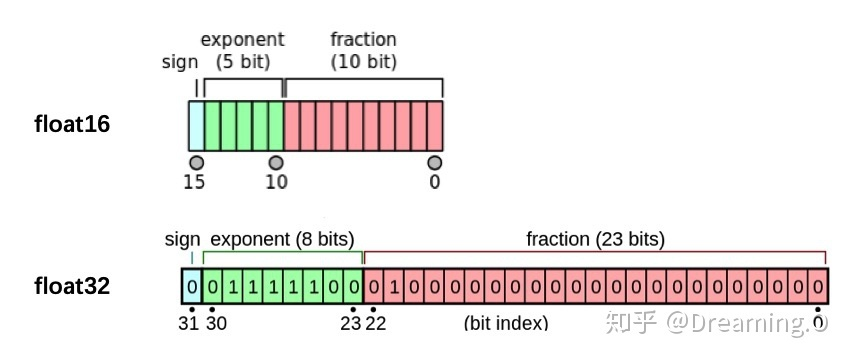

显然半精度能够减少显存占用，使得显卡可以同时加载更多数据进行计算

### 3.1、半精度训练的设置
- 1、引入 from torch.cuda.amp import autocast
- 2、forward函数指定 autocast 装饰器
- 3、训练过程： 只需在将数据输入模型及其之后的部分放入“with autocast():“
- 4、半精度训练主要适用于数据本身的size比较大（比如说3D图像、视频等）

# 引入

from torch.cuda.amp import autocast

```python
# forward指定装饰器
@autocast()   
def forward(self, x):
    ...
    return x
```

```python
# 训练过程中：指定with autocast 
 for x in train_loader:
	x = x.cuda()
	with autocast():
      output = model(x)
        ...
```

### 半精度训练案例

In [43]:
from torch.cuda.amp import autocast
# 半精度模型
class DemoModel(nn.Module):
    def __init__(self):
        super(DemoModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    @autocast() 
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x





In [44]:
#训练&验证

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
half_model = DemoModel().to(device)

# 损失函数：自定义损失函数
criterion = nn.CrossEntropyLoss()
# 优化器
optimizer = torch.optim.Adam(Resnet50_new.parameters(), lr=lr)
epoch = max_epochs

total_step = len(train_loader)
train_all_loss = []
test_all_loss = []

for i in range(epoch):
    half_model.train()
    train_total_loss = 0
    train_total_num = 0
    train_total_correct = 0

    for iter, (images,labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        with autocast():
            outputs = half_model(images)
            loss = criterion(outputs,labels)
            train_total_correct += (outputs.argmax(1) == labels).sum().item()

            #backword
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            train_total_num += labels.shape[0]
            train_total_loss += loss.item()
            print("Epoch [{}/{}], Iter [{}/{}], train_loss:{:4f}".format(i+1,epoch,iter+1,total_step,loss.item()/labels.shape[0]))
    
    half_model.eval()
    test_total_loss = 0
    test_total_correct = 0
    test_total_num = 0
    for iter,(images,labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        with autocast():
            outputs = half_model(images)
            loss = criterion(outputs,labels)
            test_total_correct += (outputs.argmax(1) == labels).sum().item()
            test_total_loss += loss.item()
            test_total_num += labels.shape[0]
            print("Epoch [{}/{}], train_loss:{:.4f}, train_acc:{:.4f}%, test_loss:{:.4f}, test_acc:{:.4f}%".format(
                i+1, epoch, train_total_loss / train_total_num, train_total_correct / train_total_num * 100, test_total_loss / test_total_num, test_total_correct / test_total_num * 100
    
    ))
    train_all_loss.append(np.round(train_total_loss / train_total_num,4))
    test_all_loss.append(np.round(test_total_loss / test_total_num,4))


Epoch [1/2], Iter [1/3125], train_loss:0.145123
Epoch [1/2], Iter [2/3125], train_loss:0.144603
Epoch [1/2], Iter [3/3125], train_loss:0.142649
Epoch [1/2], Iter [4/3125], train_loss:0.144464
Epoch [1/2], Iter [5/3125], train_loss:0.144249
Epoch [1/2], Iter [6/3125], train_loss:0.144539
Epoch [1/2], Iter [7/3125], train_loss:0.144195
Epoch [1/2], Iter [8/3125], train_loss:0.143397
Epoch [1/2], Iter [9/3125], train_loss:0.143726
Epoch [1/2], Iter [10/3125], train_loss:0.144140
Epoch [1/2], Iter [11/3125], train_loss:0.146184
Epoch [1/2], Iter [12/3125], train_loss:0.145353
Epoch [1/2], Iter [13/3125], train_loss:0.144314
Epoch [1/2], Iter [14/3125], train_loss:0.142131
Epoch [1/2], Iter [15/3125], train_loss:0.143993
Epoch [1/2], Iter [16/3125], train_loss:0.143918
Epoch [1/2], Iter [17/3125], train_loss:0.145396
Epoch [1/2], Iter [18/3125], train_loss:0.144910
Epoch [1/2], Iter [19/3125], train_loss:0.144746
Epoch [1/2], Iter [20/3125], train_loss:0.142712
Epoch [1/2], Iter [21/3125], 

Epoch [1/2], Iter [178/3125], train_loss:0.144303
Epoch [1/2], Iter [179/3125], train_loss:0.144267
Epoch [1/2], Iter [180/3125], train_loss:0.143710
Epoch [1/2], Iter [181/3125], train_loss:0.144358
Epoch [1/2], Iter [182/3125], train_loss:0.143774
Epoch [1/2], Iter [183/3125], train_loss:0.145248
Epoch [1/2], Iter [184/3125], train_loss:0.144374
Epoch [1/2], Iter [185/3125], train_loss:0.145249
Epoch [1/2], Iter [186/3125], train_loss:0.144803
Epoch [1/2], Iter [187/3125], train_loss:0.143089
Epoch [1/2], Iter [188/3125], train_loss:0.144409
Epoch [1/2], Iter [189/3125], train_loss:0.142790
Epoch [1/2], Iter [190/3125], train_loss:0.143664
Epoch [1/2], Iter [191/3125], train_loss:0.144454
Epoch [1/2], Iter [192/3125], train_loss:0.142591
Epoch [1/2], Iter [193/3125], train_loss:0.144734
Epoch [1/2], Iter [194/3125], train_loss:0.144165
Epoch [1/2], Iter [195/3125], train_loss:0.145281
Epoch [1/2], Iter [196/3125], train_loss:0.144067
Epoch [1/2], Iter [197/3125], train_loss:0.142798


Epoch [1/2], Iter [346/3125], train_loss:0.144353
Epoch [1/2], Iter [347/3125], train_loss:0.144403
Epoch [1/2], Iter [348/3125], train_loss:0.141771
Epoch [1/2], Iter [349/3125], train_loss:0.144969
Epoch [1/2], Iter [350/3125], train_loss:0.143520
Epoch [1/2], Iter [351/3125], train_loss:0.144363
Epoch [1/2], Iter [352/3125], train_loss:0.143325
Epoch [1/2], Iter [353/3125], train_loss:0.143918
Epoch [1/2], Iter [354/3125], train_loss:0.145524
Epoch [1/2], Iter [355/3125], train_loss:0.144857
Epoch [1/2], Iter [356/3125], train_loss:0.143817
Epoch [1/2], Iter [357/3125], train_loss:0.143084
Epoch [1/2], Iter [358/3125], train_loss:0.145299
Epoch [1/2], Iter [359/3125], train_loss:0.143585
Epoch [1/2], Iter [360/3125], train_loss:0.142092
Epoch [1/2], Iter [361/3125], train_loss:0.141837
Epoch [1/2], Iter [362/3125], train_loss:0.143359
Epoch [1/2], Iter [363/3125], train_loss:0.144293
Epoch [1/2], Iter [364/3125], train_loss:0.145145
Epoch [1/2], Iter [365/3125], train_loss:0.144505


Epoch [1/2], Iter [534/3125], train_loss:0.143914
Epoch [1/2], Iter [535/3125], train_loss:0.143463
Epoch [1/2], Iter [536/3125], train_loss:0.142805
Epoch [1/2], Iter [537/3125], train_loss:0.143072
Epoch [1/2], Iter [538/3125], train_loss:0.143652
Epoch [1/2], Iter [539/3125], train_loss:0.143758
Epoch [1/2], Iter [540/3125], train_loss:0.143843
Epoch [1/2], Iter [541/3125], train_loss:0.144077
Epoch [1/2], Iter [542/3125], train_loss:0.144083
Epoch [1/2], Iter [543/3125], train_loss:0.144273
Epoch [1/2], Iter [544/3125], train_loss:0.144592
Epoch [1/2], Iter [545/3125], train_loss:0.141853
Epoch [1/2], Iter [546/3125], train_loss:0.144067
Epoch [1/2], Iter [547/3125], train_loss:0.142852
Epoch [1/2], Iter [548/3125], train_loss:0.144938
Epoch [1/2], Iter [549/3125], train_loss:0.144556
Epoch [1/2], Iter [550/3125], train_loss:0.143375
Epoch [1/2], Iter [551/3125], train_loss:0.144623
Epoch [1/2], Iter [552/3125], train_loss:0.144261
Epoch [1/2], Iter [553/3125], train_loss:0.145460


Epoch [1/2], Iter [709/3125], train_loss:0.144517
Epoch [1/2], Iter [710/3125], train_loss:0.144125
Epoch [1/2], Iter [711/3125], train_loss:0.142756
Epoch [1/2], Iter [712/3125], train_loss:0.144819
Epoch [1/2], Iter [713/3125], train_loss:0.144305
Epoch [1/2], Iter [714/3125], train_loss:0.144245
Epoch [1/2], Iter [715/3125], train_loss:0.145034
Epoch [1/2], Iter [716/3125], train_loss:0.144910
Epoch [1/2], Iter [717/3125], train_loss:0.144443
Epoch [1/2], Iter [718/3125], train_loss:0.143508
Epoch [1/2], Iter [719/3125], train_loss:0.142979
Epoch [1/2], Iter [720/3125], train_loss:0.145010
Epoch [1/2], Iter [721/3125], train_loss:0.144247
Epoch [1/2], Iter [722/3125], train_loss:0.145295
Epoch [1/2], Iter [723/3125], train_loss:0.143537
Epoch [1/2], Iter [724/3125], train_loss:0.143099
Epoch [1/2], Iter [725/3125], train_loss:0.142971
Epoch [1/2], Iter [726/3125], train_loss:0.143939
Epoch [1/2], Iter [727/3125], train_loss:0.142080
Epoch [1/2], Iter [728/3125], train_loss:0.143390


Epoch [1/2], Iter [886/3125], train_loss:0.143566
Epoch [1/2], Iter [887/3125], train_loss:0.143165
Epoch [1/2], Iter [888/3125], train_loss:0.143400
Epoch [1/2], Iter [889/3125], train_loss:0.143615
Epoch [1/2], Iter [890/3125], train_loss:0.143618
Epoch [1/2], Iter [891/3125], train_loss:0.143219
Epoch [1/2], Iter [892/3125], train_loss:0.144987
Epoch [1/2], Iter [893/3125], train_loss:0.143366
Epoch [1/2], Iter [894/3125], train_loss:0.142526
Epoch [1/2], Iter [895/3125], train_loss:0.142739
Epoch [1/2], Iter [896/3125], train_loss:0.143722
Epoch [1/2], Iter [897/3125], train_loss:0.143818
Epoch [1/2], Iter [898/3125], train_loss:0.144769
Epoch [1/2], Iter [899/3125], train_loss:0.143408
Epoch [1/2], Iter [900/3125], train_loss:0.144746
Epoch [1/2], Iter [901/3125], train_loss:0.143799
Epoch [1/2], Iter [902/3125], train_loss:0.144751
Epoch [1/2], Iter [903/3125], train_loss:0.142593
Epoch [1/2], Iter [904/3125], train_loss:0.142894
Epoch [1/2], Iter [905/3125], train_loss:0.144096


Epoch [1/2], Iter [1062/3125], train_loss:0.142604
Epoch [1/2], Iter [1063/3125], train_loss:0.143565
Epoch [1/2], Iter [1064/3125], train_loss:0.143565
Epoch [1/2], Iter [1065/3125], train_loss:0.143837
Epoch [1/2], Iter [1066/3125], train_loss:0.142543
Epoch [1/2], Iter [1067/3125], train_loss:0.142937
Epoch [1/2], Iter [1068/3125], train_loss:0.142791
Epoch [1/2], Iter [1069/3125], train_loss:0.144512
Epoch [1/2], Iter [1070/3125], train_loss:0.143378
Epoch [1/2], Iter [1071/3125], train_loss:0.144531
Epoch [1/2], Iter [1072/3125], train_loss:0.144421
Epoch [1/2], Iter [1073/3125], train_loss:0.143944
Epoch [1/2], Iter [1074/3125], train_loss:0.143188
Epoch [1/2], Iter [1075/3125], train_loss:0.144417
Epoch [1/2], Iter [1076/3125], train_loss:0.143870
Epoch [1/2], Iter [1077/3125], train_loss:0.144572
Epoch [1/2], Iter [1078/3125], train_loss:0.142294
Epoch [1/2], Iter [1079/3125], train_loss:0.144546
Epoch [1/2], Iter [1080/3125], train_loss:0.142623
Epoch [1/2], Iter [1081/3125], 

Epoch [1/2], Iter [1240/3125], train_loss:0.144127
Epoch [1/2], Iter [1241/3125], train_loss:0.144186
Epoch [1/2], Iter [1242/3125], train_loss:0.143595
Epoch [1/2], Iter [1243/3125], train_loss:0.144265
Epoch [1/2], Iter [1244/3125], train_loss:0.144759
Epoch [1/2], Iter [1245/3125], train_loss:0.143969
Epoch [1/2], Iter [1246/3125], train_loss:0.144552
Epoch [1/2], Iter [1247/3125], train_loss:0.143295
Epoch [1/2], Iter [1248/3125], train_loss:0.144535
Epoch [1/2], Iter [1249/3125], train_loss:0.143148
Epoch [1/2], Iter [1250/3125], train_loss:0.143761
Epoch [1/2], Iter [1251/3125], train_loss:0.141894
Epoch [1/2], Iter [1252/3125], train_loss:0.143703
Epoch [1/2], Iter [1253/3125], train_loss:0.143913
Epoch [1/2], Iter [1254/3125], train_loss:0.143690
Epoch [1/2], Iter [1255/3125], train_loss:0.145600
Epoch [1/2], Iter [1256/3125], train_loss:0.145439
Epoch [1/2], Iter [1257/3125], train_loss:0.145078
Epoch [1/2], Iter [1258/3125], train_loss:0.143724
Epoch [1/2], Iter [1259/3125], 

Epoch [1/2], Iter [1401/3125], train_loss:0.143844
Epoch [1/2], Iter [1402/3125], train_loss:0.143268
Epoch [1/2], Iter [1403/3125], train_loss:0.145617
Epoch [1/2], Iter [1404/3125], train_loss:0.144770
Epoch [1/2], Iter [1405/3125], train_loss:0.144653
Epoch [1/2], Iter [1406/3125], train_loss:0.144107
Epoch [1/2], Iter [1407/3125], train_loss:0.144448
Epoch [1/2], Iter [1408/3125], train_loss:0.142808
Epoch [1/2], Iter [1409/3125], train_loss:0.143818
Epoch [1/2], Iter [1410/3125], train_loss:0.145061
Epoch [1/2], Iter [1411/3125], train_loss:0.142640
Epoch [1/2], Iter [1412/3125], train_loss:0.143431
Epoch [1/2], Iter [1413/3125], train_loss:0.144524
Epoch [1/2], Iter [1414/3125], train_loss:0.144385
Epoch [1/2], Iter [1415/3125], train_loss:0.142809
Epoch [1/2], Iter [1416/3125], train_loss:0.144587
Epoch [1/2], Iter [1417/3125], train_loss:0.144608
Epoch [1/2], Iter [1418/3125], train_loss:0.144227
Epoch [1/2], Iter [1419/3125], train_loss:0.143087
Epoch [1/2], Iter [1420/3125], 

Epoch [1/2], Iter [1563/3125], train_loss:0.143983
Epoch [1/2], Iter [1564/3125], train_loss:0.142121
Epoch [1/2], Iter [1565/3125], train_loss:0.143437
Epoch [1/2], Iter [1566/3125], train_loss:0.145382
Epoch [1/2], Iter [1567/3125], train_loss:0.143641
Epoch [1/2], Iter [1568/3125], train_loss:0.145593
Epoch [1/2], Iter [1569/3125], train_loss:0.143672
Epoch [1/2], Iter [1570/3125], train_loss:0.144536
Epoch [1/2], Iter [1571/3125], train_loss:0.145059
Epoch [1/2], Iter [1572/3125], train_loss:0.142913
Epoch [1/2], Iter [1573/3125], train_loss:0.143935
Epoch [1/2], Iter [1574/3125], train_loss:0.142209
Epoch [1/2], Iter [1575/3125], train_loss:0.144704
Epoch [1/2], Iter [1576/3125], train_loss:0.145256
Epoch [1/2], Iter [1577/3125], train_loss:0.144652
Epoch [1/2], Iter [1578/3125], train_loss:0.142689
Epoch [1/2], Iter [1579/3125], train_loss:0.144541
Epoch [1/2], Iter [1580/3125], train_loss:0.144296
Epoch [1/2], Iter [1581/3125], train_loss:0.145190
Epoch [1/2], Iter [1582/3125], 

Epoch [1/2], Iter [1740/3125], train_loss:0.143961
Epoch [1/2], Iter [1741/3125], train_loss:0.143450
Epoch [1/2], Iter [1742/3125], train_loss:0.143193
Epoch [1/2], Iter [1743/3125], train_loss:0.143672
Epoch [1/2], Iter [1744/3125], train_loss:0.143723
Epoch [1/2], Iter [1745/3125], train_loss:0.146398
Epoch [1/2], Iter [1746/3125], train_loss:0.144666
Epoch [1/2], Iter [1747/3125], train_loss:0.144321
Epoch [1/2], Iter [1748/3125], train_loss:0.143597
Epoch [1/2], Iter [1749/3125], train_loss:0.143754
Epoch [1/2], Iter [1750/3125], train_loss:0.144281
Epoch [1/2], Iter [1751/3125], train_loss:0.146180
Epoch [1/2], Iter [1752/3125], train_loss:0.143114
Epoch [1/2], Iter [1753/3125], train_loss:0.142879
Epoch [1/2], Iter [1754/3125], train_loss:0.143066
Epoch [1/2], Iter [1755/3125], train_loss:0.144403
Epoch [1/2], Iter [1756/3125], train_loss:0.143491
Epoch [1/2], Iter [1757/3125], train_loss:0.144278
Epoch [1/2], Iter [1758/3125], train_loss:0.144270
Epoch [1/2], Iter [1759/3125], 

Epoch [1/2], Iter [1917/3125], train_loss:0.144401
Epoch [1/2], Iter [1918/3125], train_loss:0.143320
Epoch [1/2], Iter [1919/3125], train_loss:0.145524
Epoch [1/2], Iter [1920/3125], train_loss:0.144696
Epoch [1/2], Iter [1921/3125], train_loss:0.143110
Epoch [1/2], Iter [1922/3125], train_loss:0.144066
Epoch [1/2], Iter [1923/3125], train_loss:0.143514
Epoch [1/2], Iter [1924/3125], train_loss:0.142873
Epoch [1/2], Iter [1925/3125], train_loss:0.143869
Epoch [1/2], Iter [1926/3125], train_loss:0.144686
Epoch [1/2], Iter [1927/3125], train_loss:0.144182
Epoch [1/2], Iter [1928/3125], train_loss:0.144357
Epoch [1/2], Iter [1929/3125], train_loss:0.143219
Epoch [1/2], Iter [1930/3125], train_loss:0.144602
Epoch [1/2], Iter [1931/3125], train_loss:0.143951
Epoch [1/2], Iter [1932/3125], train_loss:0.143895
Epoch [1/2], Iter [1933/3125], train_loss:0.145482
Epoch [1/2], Iter [1934/3125], train_loss:0.142999
Epoch [1/2], Iter [1935/3125], train_loss:0.143940
Epoch [1/2], Iter [1936/3125], 

Epoch [1/2], Iter [2095/3125], train_loss:0.145574
Epoch [1/2], Iter [2096/3125], train_loss:0.144049
Epoch [1/2], Iter [2097/3125], train_loss:0.144942
Epoch [1/2], Iter [2098/3125], train_loss:0.144347
Epoch [1/2], Iter [2099/3125], train_loss:0.143462
Epoch [1/2], Iter [2100/3125], train_loss:0.141226
Epoch [1/2], Iter [2101/3125], train_loss:0.144108
Epoch [1/2], Iter [2102/3125], train_loss:0.143105
Epoch [1/2], Iter [2103/3125], train_loss:0.144368
Epoch [1/2], Iter [2104/3125], train_loss:0.144280
Epoch [1/2], Iter [2105/3125], train_loss:0.143625
Epoch [1/2], Iter [2106/3125], train_loss:0.143109
Epoch [1/2], Iter [2107/3125], train_loss:0.144015
Epoch [1/2], Iter [2108/3125], train_loss:0.144688
Epoch [1/2], Iter [2109/3125], train_loss:0.143459
Epoch [1/2], Iter [2110/3125], train_loss:0.145338
Epoch [1/2], Iter [2111/3125], train_loss:0.144176
Epoch [1/2], Iter [2112/3125], train_loss:0.143381
Epoch [1/2], Iter [2113/3125], train_loss:0.143703
Epoch [1/2], Iter [2114/3125], 

Epoch [1/2], Iter [2277/3125], train_loss:0.144048
Epoch [1/2], Iter [2278/3125], train_loss:0.143889
Epoch [1/2], Iter [2279/3125], train_loss:0.144102
Epoch [1/2], Iter [2280/3125], train_loss:0.144539
Epoch [1/2], Iter [2281/3125], train_loss:0.143488
Epoch [1/2], Iter [2282/3125], train_loss:0.143994
Epoch [1/2], Iter [2283/3125], train_loss:0.144321
Epoch [1/2], Iter [2284/3125], train_loss:0.142902
Epoch [1/2], Iter [2285/3125], train_loss:0.144954
Epoch [1/2], Iter [2286/3125], train_loss:0.144875
Epoch [1/2], Iter [2287/3125], train_loss:0.144440
Epoch [1/2], Iter [2288/3125], train_loss:0.143496
Epoch [1/2], Iter [2289/3125], train_loss:0.144408
Epoch [1/2], Iter [2290/3125], train_loss:0.143076
Epoch [1/2], Iter [2291/3125], train_loss:0.144952
Epoch [1/2], Iter [2292/3125], train_loss:0.142678
Epoch [1/2], Iter [2293/3125], train_loss:0.144356
Epoch [1/2], Iter [2294/3125], train_loss:0.144050
Epoch [1/2], Iter [2295/3125], train_loss:0.142533
Epoch [1/2], Iter [2296/3125], 

Epoch [1/2], Iter [2462/3125], train_loss:0.142491
Epoch [1/2], Iter [2463/3125], train_loss:0.144053
Epoch [1/2], Iter [2464/3125], train_loss:0.144557
Epoch [1/2], Iter [2465/3125], train_loss:0.143731
Epoch [1/2], Iter [2466/3125], train_loss:0.145374
Epoch [1/2], Iter [2467/3125], train_loss:0.143314
Epoch [1/2], Iter [2468/3125], train_loss:0.143493
Epoch [1/2], Iter [2469/3125], train_loss:0.143275
Epoch [1/2], Iter [2470/3125], train_loss:0.144532
Epoch [1/2], Iter [2471/3125], train_loss:0.144118
Epoch [1/2], Iter [2472/3125], train_loss:0.145079
Epoch [1/2], Iter [2473/3125], train_loss:0.144283
Epoch [1/2], Iter [2474/3125], train_loss:0.144988
Epoch [1/2], Iter [2475/3125], train_loss:0.144109
Epoch [1/2], Iter [2476/3125], train_loss:0.145141
Epoch [1/2], Iter [2477/3125], train_loss:0.143784
Epoch [1/2], Iter [2478/3125], train_loss:0.144066
Epoch [1/2], Iter [2479/3125], train_loss:0.144671
Epoch [1/2], Iter [2480/3125], train_loss:0.144818
Epoch [1/2], Iter [2481/3125], 

Epoch [1/2], Iter [2647/3125], train_loss:0.144602
Epoch [1/2], Iter [2648/3125], train_loss:0.143527
Epoch [1/2], Iter [2649/3125], train_loss:0.142852
Epoch [1/2], Iter [2650/3125], train_loss:0.145023
Epoch [1/2], Iter [2651/3125], train_loss:0.141899
Epoch [1/2], Iter [2652/3125], train_loss:0.145086
Epoch [1/2], Iter [2653/3125], train_loss:0.143586
Epoch [1/2], Iter [2654/3125], train_loss:0.145163
Epoch [1/2], Iter [2655/3125], train_loss:0.144321
Epoch [1/2], Iter [2656/3125], train_loss:0.143783
Epoch [1/2], Iter [2657/3125], train_loss:0.145278
Epoch [1/2], Iter [2658/3125], train_loss:0.144103
Epoch [1/2], Iter [2659/3125], train_loss:0.142452
Epoch [1/2], Iter [2660/3125], train_loss:0.142492
Epoch [1/2], Iter [2661/3125], train_loss:0.144963
Epoch [1/2], Iter [2662/3125], train_loss:0.143000
Epoch [1/2], Iter [2663/3125], train_loss:0.144481
Epoch [1/2], Iter [2664/3125], train_loss:0.144055
Epoch [1/2], Iter [2665/3125], train_loss:0.144353
Epoch [1/2], Iter [2666/3125], 

Epoch [1/2], Iter [2833/3125], train_loss:0.145325
Epoch [1/2], Iter [2834/3125], train_loss:0.143195
Epoch [1/2], Iter [2835/3125], train_loss:0.143386
Epoch [1/2], Iter [2836/3125], train_loss:0.143796
Epoch [1/2], Iter [2837/3125], train_loss:0.143619
Epoch [1/2], Iter [2838/3125], train_loss:0.143824
Epoch [1/2], Iter [2839/3125], train_loss:0.145041
Epoch [1/2], Iter [2840/3125], train_loss:0.144156
Epoch [1/2], Iter [2841/3125], train_loss:0.144186
Epoch [1/2], Iter [2842/3125], train_loss:0.142785
Epoch [1/2], Iter [2843/3125], train_loss:0.144664
Epoch [1/2], Iter [2844/3125], train_loss:0.143627
Epoch [1/2], Iter [2845/3125], train_loss:0.143006
Epoch [1/2], Iter [2846/3125], train_loss:0.144436
Epoch [1/2], Iter [2847/3125], train_loss:0.144083
Epoch [1/2], Iter [2848/3125], train_loss:0.144224
Epoch [1/2], Iter [2849/3125], train_loss:0.143347
Epoch [1/2], Iter [2850/3125], train_loss:0.143182
Epoch [1/2], Iter [2851/3125], train_loss:0.143745
Epoch [1/2], Iter [2852/3125], 

Epoch [1/2], Iter [3017/3125], train_loss:0.143761
Epoch [1/2], Iter [3018/3125], train_loss:0.143270
Epoch [1/2], Iter [3019/3125], train_loss:0.144641
Epoch [1/2], Iter [3020/3125], train_loss:0.143964
Epoch [1/2], Iter [3021/3125], train_loss:0.145061
Epoch [1/2], Iter [3022/3125], train_loss:0.142531
Epoch [1/2], Iter [3023/3125], train_loss:0.143364
Epoch [1/2], Iter [3024/3125], train_loss:0.144739
Epoch [1/2], Iter [3025/3125], train_loss:0.143609
Epoch [1/2], Iter [3026/3125], train_loss:0.143417
Epoch [1/2], Iter [3027/3125], train_loss:0.144802
Epoch [1/2], Iter [3028/3125], train_loss:0.143367
Epoch [1/2], Iter [3029/3125], train_loss:0.144781
Epoch [1/2], Iter [3030/3125], train_loss:0.144847
Epoch [1/2], Iter [3031/3125], train_loss:0.143750
Epoch [1/2], Iter [3032/3125], train_loss:0.143195
Epoch [1/2], Iter [3033/3125], train_loss:0.143907
Epoch [1/2], Iter [3034/3125], train_loss:0.144760
Epoch [1/2], Iter [3035/3125], train_loss:0.143240
Epoch [1/2], Iter [3036/3125], 

Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1441, test_acc:10.0490%
Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1441, test_acc:9.9760%
Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.4953%
Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1441, test_acc:10.4167%
Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1441, test_acc:10.4545%
Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1441, test_acc:10.2679%
Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1441, test_acc:10.1974%
Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1441, test_acc:10.0216%
Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1441, test_acc:10.2754%
Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1441, test_acc:10.1042%
Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1441, test_acc:10.0410%
Epoch [1/2], train_loss:0.1440, t

Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.2917%
Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.2649%
Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.2796%
Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.2533%
Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.2679%
Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.2823%
Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.2564%
Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.2309%
Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.3244%
Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.3774%
Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1439, test_acc:10.4297%
Epoch [1/2], train_loss:0.1440, 

Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1439, test_acc:10.6022%
Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1439, test_acc:10.5847%
Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1439, test_acc:10.5924%
Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1439, test_acc:10.6500%
Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1439, test_acc:10.6823%
Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1439, test_acc:10.6399%
Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1439, test_acc:10.6472%
Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1439, test_acc:10.6053%
Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.6127%
Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.5713%
Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.6031%
Epoch [1/2], train_loss:0.1440, 

Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.0694%
Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.0765%
Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.0654%
Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.0543%
Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.0614%
Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.0684%
Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.0395%
Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.0287%
Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.0357%
Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.0071%
Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:9.9787%
Epoch [1/2], train_loss:0.1440, t

Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.0962%
Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.0882%
Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.0932%
Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.0852%
Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.0773%
Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.1080%
Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.0873%
Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.0794%
Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.0971%
Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.1148%
Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.1324%
Epoch [1/2], train_loss:0.1440, 

Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:9.9779%
Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.0020%
Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.0060%
Epoch [1/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.0000%
Epoch [2/2], Iter [1/3125], train_loss:0.144268
Epoch [2/2], Iter [2/3125], train_loss:0.143500
Epoch [2/2], Iter [3/3125], train_loss:0.144605
Epoch [2/2], Iter [4/3125], train_loss:0.143070
Epoch [2/2], Iter [5/3125], train_loss:0.144434
Epoch [2/2], Iter [6/3125], train_loss:0.143728
Epoch [2/2], Iter [7/3125], train_loss:0.143243
Epoch [2/2], Iter [8/3125], train_loss:0.142683
Epoch [2/2], Iter [9/3125], train_loss:0.143534
Epoch [2/2], Iter [10/3125], train_loss:0.142066
Epoch [2/2], Iter [11/3125], train_loss:0.145110
Epoch [2/2], Iter [12/3125], train_loss:0.145814
Epoch [2/2], Iter [13/3125], train_loss:0.142881
Epoch [2/2], Iter [14

Epoch [2/2], Iter [183/3125], train_loss:0.144852
Epoch [2/2], Iter [184/3125], train_loss:0.145115
Epoch [2/2], Iter [185/3125], train_loss:0.144001
Epoch [2/2], Iter [186/3125], train_loss:0.143442
Epoch [2/2], Iter [187/3125], train_loss:0.144112
Epoch [2/2], Iter [188/3125], train_loss:0.144492
Epoch [2/2], Iter [189/3125], train_loss:0.143379
Epoch [2/2], Iter [190/3125], train_loss:0.144725
Epoch [2/2], Iter [191/3125], train_loss:0.143464
Epoch [2/2], Iter [192/3125], train_loss:0.143090
Epoch [2/2], Iter [193/3125], train_loss:0.142695
Epoch [2/2], Iter [194/3125], train_loss:0.145640
Epoch [2/2], Iter [195/3125], train_loss:0.145253
Epoch [2/2], Iter [196/3125], train_loss:0.144886
Epoch [2/2], Iter [197/3125], train_loss:0.143255
Epoch [2/2], Iter [198/3125], train_loss:0.144008
Epoch [2/2], Iter [199/3125], train_loss:0.142820
Epoch [2/2], Iter [200/3125], train_loss:0.145200
Epoch [2/2], Iter [201/3125], train_loss:0.143884
Epoch [2/2], Iter [202/3125], train_loss:0.143713


Epoch [2/2], Iter [361/3125], train_loss:0.144698
Epoch [2/2], Iter [362/3125], train_loss:0.142400
Epoch [2/2], Iter [363/3125], train_loss:0.143792
Epoch [2/2], Iter [364/3125], train_loss:0.144898
Epoch [2/2], Iter [365/3125], train_loss:0.142545
Epoch [2/2], Iter [366/3125], train_loss:0.144898
Epoch [2/2], Iter [367/3125], train_loss:0.144106
Epoch [2/2], Iter [368/3125], train_loss:0.145724
Epoch [2/2], Iter [369/3125], train_loss:0.143750
Epoch [2/2], Iter [370/3125], train_loss:0.143088
Epoch [2/2], Iter [371/3125], train_loss:0.144603
Epoch [2/2], Iter [372/3125], train_loss:0.144719
Epoch [2/2], Iter [373/3125], train_loss:0.144378
Epoch [2/2], Iter [374/3125], train_loss:0.145297
Epoch [2/2], Iter [375/3125], train_loss:0.143653
Epoch [2/2], Iter [376/3125], train_loss:0.142078
Epoch [2/2], Iter [377/3125], train_loss:0.142474
Epoch [2/2], Iter [378/3125], train_loss:0.145086
Epoch [2/2], Iter [379/3125], train_loss:0.143891
Epoch [2/2], Iter [380/3125], train_loss:0.143823


Epoch [2/2], Iter [550/3125], train_loss:0.144407
Epoch [2/2], Iter [551/3125], train_loss:0.143035
Epoch [2/2], Iter [552/3125], train_loss:0.144164
Epoch [2/2], Iter [553/3125], train_loss:0.144285
Epoch [2/2], Iter [554/3125], train_loss:0.144310
Epoch [2/2], Iter [555/3125], train_loss:0.144027
Epoch [2/2], Iter [556/3125], train_loss:0.145306
Epoch [2/2], Iter [557/3125], train_loss:0.143419
Epoch [2/2], Iter [558/3125], train_loss:0.143495
Epoch [2/2], Iter [559/3125], train_loss:0.144807
Epoch [2/2], Iter [560/3125], train_loss:0.143957
Epoch [2/2], Iter [561/3125], train_loss:0.143188
Epoch [2/2], Iter [562/3125], train_loss:0.144172
Epoch [2/2], Iter [563/3125], train_loss:0.144180
Epoch [2/2], Iter [564/3125], train_loss:0.143870
Epoch [2/2], Iter [565/3125], train_loss:0.142312
Epoch [2/2], Iter [566/3125], train_loss:0.144081
Epoch [2/2], Iter [567/3125], train_loss:0.143015
Epoch [2/2], Iter [568/3125], train_loss:0.144368
Epoch [2/2], Iter [569/3125], train_loss:0.144287


Epoch [2/2], Iter [720/3125], train_loss:0.143267
Epoch [2/2], Iter [721/3125], train_loss:0.142994
Epoch [2/2], Iter [722/3125], train_loss:0.143926
Epoch [2/2], Iter [723/3125], train_loss:0.143666
Epoch [2/2], Iter [724/3125], train_loss:0.143765
Epoch [2/2], Iter [725/3125], train_loss:0.144841
Epoch [2/2], Iter [726/3125], train_loss:0.142475
Epoch [2/2], Iter [727/3125], train_loss:0.143215
Epoch [2/2], Iter [728/3125], train_loss:0.145398
Epoch [2/2], Iter [729/3125], train_loss:0.143368
Epoch [2/2], Iter [730/3125], train_loss:0.144948
Epoch [2/2], Iter [731/3125], train_loss:0.143911
Epoch [2/2], Iter [732/3125], train_loss:0.142944
Epoch [2/2], Iter [733/3125], train_loss:0.144724
Epoch [2/2], Iter [734/3125], train_loss:0.143874
Epoch [2/2], Iter [735/3125], train_loss:0.144617
Epoch [2/2], Iter [736/3125], train_loss:0.142974
Epoch [2/2], Iter [737/3125], train_loss:0.144212
Epoch [2/2], Iter [738/3125], train_loss:0.144664
Epoch [2/2], Iter [739/3125], train_loss:0.143400


Epoch [2/2], Iter [896/3125], train_loss:0.143205
Epoch [2/2], Iter [897/3125], train_loss:0.142443
Epoch [2/2], Iter [898/3125], train_loss:0.144856
Epoch [2/2], Iter [899/3125], train_loss:0.143078
Epoch [2/2], Iter [900/3125], train_loss:0.145195
Epoch [2/2], Iter [901/3125], train_loss:0.144094
Epoch [2/2], Iter [902/3125], train_loss:0.142664
Epoch [2/2], Iter [903/3125], train_loss:0.145138
Epoch [2/2], Iter [904/3125], train_loss:0.144074
Epoch [2/2], Iter [905/3125], train_loss:0.143978
Epoch [2/2], Iter [906/3125], train_loss:0.143167
Epoch [2/2], Iter [907/3125], train_loss:0.143749
Epoch [2/2], Iter [908/3125], train_loss:0.143886
Epoch [2/2], Iter [909/3125], train_loss:0.143040
Epoch [2/2], Iter [910/3125], train_loss:0.143592
Epoch [2/2], Iter [911/3125], train_loss:0.142112
Epoch [2/2], Iter [912/3125], train_loss:0.143336
Epoch [2/2], Iter [913/3125], train_loss:0.142810
Epoch [2/2], Iter [914/3125], train_loss:0.143817
Epoch [2/2], Iter [915/3125], train_loss:0.144812


Epoch [2/2], Iter [1064/3125], train_loss:0.143045
Epoch [2/2], Iter [1065/3125], train_loss:0.146569
Epoch [2/2], Iter [1066/3125], train_loss:0.145604
Epoch [2/2], Iter [1067/3125], train_loss:0.144625
Epoch [2/2], Iter [1068/3125], train_loss:0.143025
Epoch [2/2], Iter [1069/3125], train_loss:0.143737
Epoch [2/2], Iter [1070/3125], train_loss:0.145351
Epoch [2/2], Iter [1071/3125], train_loss:0.144250
Epoch [2/2], Iter [1072/3125], train_loss:0.143552
Epoch [2/2], Iter [1073/3125], train_loss:0.143157
Epoch [2/2], Iter [1074/3125], train_loss:0.144244
Epoch [2/2], Iter [1075/3125], train_loss:0.143400
Epoch [2/2], Iter [1076/3125], train_loss:0.144469
Epoch [2/2], Iter [1077/3125], train_loss:0.144852
Epoch [2/2], Iter [1078/3125], train_loss:0.145474
Epoch [2/2], Iter [1079/3125], train_loss:0.144307
Epoch [2/2], Iter [1080/3125], train_loss:0.140464
Epoch [2/2], Iter [1081/3125], train_loss:0.144020
Epoch [2/2], Iter [1082/3125], train_loss:0.143939
Epoch [2/2], Iter [1083/3125], 

Epoch [2/2], Iter [1239/3125], train_loss:0.144182
Epoch [2/2], Iter [1240/3125], train_loss:0.143390
Epoch [2/2], Iter [1241/3125], train_loss:0.143305
Epoch [2/2], Iter [1242/3125], train_loss:0.143237
Epoch [2/2], Iter [1243/3125], train_loss:0.143531
Epoch [2/2], Iter [1244/3125], train_loss:0.144406
Epoch [2/2], Iter [1245/3125], train_loss:0.143115
Epoch [2/2], Iter [1246/3125], train_loss:0.142730
Epoch [2/2], Iter [1247/3125], train_loss:0.143613
Epoch [2/2], Iter [1248/3125], train_loss:0.143240
Epoch [2/2], Iter [1249/3125], train_loss:0.143213
Epoch [2/2], Iter [1250/3125], train_loss:0.144133
Epoch [2/2], Iter [1251/3125], train_loss:0.143535
Epoch [2/2], Iter [1252/3125], train_loss:0.143049
Epoch [2/2], Iter [1253/3125], train_loss:0.143468
Epoch [2/2], Iter [1254/3125], train_loss:0.144630
Epoch [2/2], Iter [1255/3125], train_loss:0.144798
Epoch [2/2], Iter [1256/3125], train_loss:0.144535
Epoch [2/2], Iter [1257/3125], train_loss:0.142839
Epoch [2/2], Iter [1258/3125], 

Epoch [2/2], Iter [1404/3125], train_loss:0.144224
Epoch [2/2], Iter [1405/3125], train_loss:0.144076
Epoch [2/2], Iter [1406/3125], train_loss:0.144493
Epoch [2/2], Iter [1407/3125], train_loss:0.144611
Epoch [2/2], Iter [1408/3125], train_loss:0.143476
Epoch [2/2], Iter [1409/3125], train_loss:0.144010
Epoch [2/2], Iter [1410/3125], train_loss:0.143999
Epoch [2/2], Iter [1411/3125], train_loss:0.143238
Epoch [2/2], Iter [1412/3125], train_loss:0.144882
Epoch [2/2], Iter [1413/3125], train_loss:0.143426
Epoch [2/2], Iter [1414/3125], train_loss:0.144926
Epoch [2/2], Iter [1415/3125], train_loss:0.143962
Epoch [2/2], Iter [1416/3125], train_loss:0.143496
Epoch [2/2], Iter [1417/3125], train_loss:0.144390
Epoch [2/2], Iter [1418/3125], train_loss:0.143774
Epoch [2/2], Iter [1419/3125], train_loss:0.142988
Epoch [2/2], Iter [1420/3125], train_loss:0.145371
Epoch [2/2], Iter [1421/3125], train_loss:0.145207
Epoch [2/2], Iter [1422/3125], train_loss:0.143282
Epoch [2/2], Iter [1423/3125], 

Epoch [2/2], Iter [1569/3125], train_loss:0.145970
Epoch [2/2], Iter [1570/3125], train_loss:0.144244
Epoch [2/2], Iter [1571/3125], train_loss:0.143344
Epoch [2/2], Iter [1572/3125], train_loss:0.142591
Epoch [2/2], Iter [1573/3125], train_loss:0.143932
Epoch [2/2], Iter [1574/3125], train_loss:0.144230
Epoch [2/2], Iter [1575/3125], train_loss:0.144525
Epoch [2/2], Iter [1576/3125], train_loss:0.144858
Epoch [2/2], Iter [1577/3125], train_loss:0.144251
Epoch [2/2], Iter [1578/3125], train_loss:0.142077
Epoch [2/2], Iter [1579/3125], train_loss:0.144723
Epoch [2/2], Iter [1580/3125], train_loss:0.145696
Epoch [2/2], Iter [1581/3125], train_loss:0.143639
Epoch [2/2], Iter [1582/3125], train_loss:0.144549
Epoch [2/2], Iter [1583/3125], train_loss:0.143477
Epoch [2/2], Iter [1584/3125], train_loss:0.143847
Epoch [2/2], Iter [1585/3125], train_loss:0.145948
Epoch [2/2], Iter [1586/3125], train_loss:0.144670
Epoch [2/2], Iter [1587/3125], train_loss:0.143221
Epoch [2/2], Iter [1588/3125], 

Epoch [2/2], Iter [1745/3125], train_loss:0.144294
Epoch [2/2], Iter [1746/3125], train_loss:0.147011
Epoch [2/2], Iter [1747/3125], train_loss:0.144049
Epoch [2/2], Iter [1748/3125], train_loss:0.143922
Epoch [2/2], Iter [1749/3125], train_loss:0.143436
Epoch [2/2], Iter [1750/3125], train_loss:0.144973
Epoch [2/2], Iter [1751/3125], train_loss:0.144619
Epoch [2/2], Iter [1752/3125], train_loss:0.144191
Epoch [2/2], Iter [1753/3125], train_loss:0.144302
Epoch [2/2], Iter [1754/3125], train_loss:0.144738
Epoch [2/2], Iter [1755/3125], train_loss:0.143002
Epoch [2/2], Iter [1756/3125], train_loss:0.143834
Epoch [2/2], Iter [1757/3125], train_loss:0.143469
Epoch [2/2], Iter [1758/3125], train_loss:0.144034
Epoch [2/2], Iter [1759/3125], train_loss:0.142793
Epoch [2/2], Iter [1760/3125], train_loss:0.141467
Epoch [2/2], Iter [1761/3125], train_loss:0.144870
Epoch [2/2], Iter [1762/3125], train_loss:0.143171
Epoch [2/2], Iter [1763/3125], train_loss:0.143685
Epoch [2/2], Iter [1764/3125], 

Epoch [2/2], Iter [1912/3125], train_loss:0.143710
Epoch [2/2], Iter [1913/3125], train_loss:0.143145
Epoch [2/2], Iter [1914/3125], train_loss:0.144562
Epoch [2/2], Iter [1915/3125], train_loss:0.144927
Epoch [2/2], Iter [1916/3125], train_loss:0.143002
Epoch [2/2], Iter [1917/3125], train_loss:0.142790
Epoch [2/2], Iter [1918/3125], train_loss:0.144505
Epoch [2/2], Iter [1919/3125], train_loss:0.143337
Epoch [2/2], Iter [1920/3125], train_loss:0.143202
Epoch [2/2], Iter [1921/3125], train_loss:0.144669
Epoch [2/2], Iter [1922/3125], train_loss:0.144273
Epoch [2/2], Iter [1923/3125], train_loss:0.143966
Epoch [2/2], Iter [1924/3125], train_loss:0.144727
Epoch [2/2], Iter [1925/3125], train_loss:0.143673
Epoch [2/2], Iter [1926/3125], train_loss:0.145069
Epoch [2/2], Iter [1927/3125], train_loss:0.142539
Epoch [2/2], Iter [1928/3125], train_loss:0.144243
Epoch [2/2], Iter [1929/3125], train_loss:0.143493
Epoch [2/2], Iter [1930/3125], train_loss:0.142178
Epoch [2/2], Iter [1931/3125], 

Epoch [2/2], Iter [2084/3125], train_loss:0.142986
Epoch [2/2], Iter [2085/3125], train_loss:0.145435
Epoch [2/2], Iter [2086/3125], train_loss:0.144279
Epoch [2/2], Iter [2087/3125], train_loss:0.142707
Epoch [2/2], Iter [2088/3125], train_loss:0.144029
Epoch [2/2], Iter [2089/3125], train_loss:0.143849
Epoch [2/2], Iter [2090/3125], train_loss:0.143174
Epoch [2/2], Iter [2091/3125], train_loss:0.144878
Epoch [2/2], Iter [2092/3125], train_loss:0.144295
Epoch [2/2], Iter [2093/3125], train_loss:0.143926
Epoch [2/2], Iter [2094/3125], train_loss:0.143205
Epoch [2/2], Iter [2095/3125], train_loss:0.143756
Epoch [2/2], Iter [2096/3125], train_loss:0.145025
Epoch [2/2], Iter [2097/3125], train_loss:0.143542
Epoch [2/2], Iter [2098/3125], train_loss:0.144891
Epoch [2/2], Iter [2099/3125], train_loss:0.144579
Epoch [2/2], Iter [2100/3125], train_loss:0.144199
Epoch [2/2], Iter [2101/3125], train_loss:0.143553
Epoch [2/2], Iter [2102/3125], train_loss:0.144253
Epoch [2/2], Iter [2103/3125], 

Epoch [2/2], Iter [2254/3125], train_loss:0.143367
Epoch [2/2], Iter [2255/3125], train_loss:0.143656
Epoch [2/2], Iter [2256/3125], train_loss:0.144857
Epoch [2/2], Iter [2257/3125], train_loss:0.143877
Epoch [2/2], Iter [2258/3125], train_loss:0.144580
Epoch [2/2], Iter [2259/3125], train_loss:0.142902
Epoch [2/2], Iter [2260/3125], train_loss:0.143284
Epoch [2/2], Iter [2261/3125], train_loss:0.144460
Epoch [2/2], Iter [2262/3125], train_loss:0.144655
Epoch [2/2], Iter [2263/3125], train_loss:0.143450
Epoch [2/2], Iter [2264/3125], train_loss:0.143677
Epoch [2/2], Iter [2265/3125], train_loss:0.142612
Epoch [2/2], Iter [2266/3125], train_loss:0.145227
Epoch [2/2], Iter [2267/3125], train_loss:0.145378
Epoch [2/2], Iter [2268/3125], train_loss:0.143607
Epoch [2/2], Iter [2269/3125], train_loss:0.144358
Epoch [2/2], Iter [2270/3125], train_loss:0.143349
Epoch [2/2], Iter [2271/3125], train_loss:0.144656
Epoch [2/2], Iter [2272/3125], train_loss:0.145226
Epoch [2/2], Iter [2273/3125], 

Epoch [2/2], Iter [2428/3125], train_loss:0.143786
Epoch [2/2], Iter [2429/3125], train_loss:0.143678
Epoch [2/2], Iter [2430/3125], train_loss:0.145007
Epoch [2/2], Iter [2431/3125], train_loss:0.143509
Epoch [2/2], Iter [2432/3125], train_loss:0.142896
Epoch [2/2], Iter [2433/3125], train_loss:0.144657
Epoch [2/2], Iter [2434/3125], train_loss:0.144977
Epoch [2/2], Iter [2435/3125], train_loss:0.143149
Epoch [2/2], Iter [2436/3125], train_loss:0.143983
Epoch [2/2], Iter [2437/3125], train_loss:0.145426
Epoch [2/2], Iter [2438/3125], train_loss:0.143099
Epoch [2/2], Iter [2439/3125], train_loss:0.142941
Epoch [2/2], Iter [2440/3125], train_loss:0.144217
Epoch [2/2], Iter [2441/3125], train_loss:0.144029
Epoch [2/2], Iter [2442/3125], train_loss:0.143203
Epoch [2/2], Iter [2443/3125], train_loss:0.143934
Epoch [2/2], Iter [2444/3125], train_loss:0.143677
Epoch [2/2], Iter [2445/3125], train_loss:0.143183
Epoch [2/2], Iter [2446/3125], train_loss:0.142921
Epoch [2/2], Iter [2447/3125], 

Epoch [2/2], Iter [2589/3125], train_loss:0.145503
Epoch [2/2], Iter [2590/3125], train_loss:0.145498
Epoch [2/2], Iter [2591/3125], train_loss:0.143501
Epoch [2/2], Iter [2592/3125], train_loss:0.143780
Epoch [2/2], Iter [2593/3125], train_loss:0.143399
Epoch [2/2], Iter [2594/3125], train_loss:0.144164
Epoch [2/2], Iter [2595/3125], train_loss:0.144976
Epoch [2/2], Iter [2596/3125], train_loss:0.141807
Epoch [2/2], Iter [2597/3125], train_loss:0.143069
Epoch [2/2], Iter [2598/3125], train_loss:0.144576
Epoch [2/2], Iter [2599/3125], train_loss:0.142891
Epoch [2/2], Iter [2600/3125], train_loss:0.144699
Epoch [2/2], Iter [2601/3125], train_loss:0.145018
Epoch [2/2], Iter [2602/3125], train_loss:0.143250
Epoch [2/2], Iter [2603/3125], train_loss:0.145304
Epoch [2/2], Iter [2604/3125], train_loss:0.145309
Epoch [2/2], Iter [2605/3125], train_loss:0.143330
Epoch [2/2], Iter [2606/3125], train_loss:0.144615
Epoch [2/2], Iter [2607/3125], train_loss:0.143880
Epoch [2/2], Iter [2608/3125], 

Epoch [2/2], Iter [2754/3125], train_loss:0.143569
Epoch [2/2], Iter [2755/3125], train_loss:0.144361
Epoch [2/2], Iter [2756/3125], train_loss:0.143461
Epoch [2/2], Iter [2757/3125], train_loss:0.143996
Epoch [2/2], Iter [2758/3125], train_loss:0.143918
Epoch [2/2], Iter [2759/3125], train_loss:0.143663
Epoch [2/2], Iter [2760/3125], train_loss:0.144662
Epoch [2/2], Iter [2761/3125], train_loss:0.145421
Epoch [2/2], Iter [2762/3125], train_loss:0.143937
Epoch [2/2], Iter [2763/3125], train_loss:0.144078
Epoch [2/2], Iter [2764/3125], train_loss:0.144043
Epoch [2/2], Iter [2765/3125], train_loss:0.143312
Epoch [2/2], Iter [2766/3125], train_loss:0.144220
Epoch [2/2], Iter [2767/3125], train_loss:0.144149
Epoch [2/2], Iter [2768/3125], train_loss:0.145407
Epoch [2/2], Iter [2769/3125], train_loss:0.142391
Epoch [2/2], Iter [2770/3125], train_loss:0.144604
Epoch [2/2], Iter [2771/3125], train_loss:0.142564
Epoch [2/2], Iter [2772/3125], train_loss:0.143830
Epoch [2/2], Iter [2773/3125], 

Epoch [2/2], Iter [2928/3125], train_loss:0.142395
Epoch [2/2], Iter [2929/3125], train_loss:0.144055
Epoch [2/2], Iter [2930/3125], train_loss:0.145205
Epoch [2/2], Iter [2931/3125], train_loss:0.145022
Epoch [2/2], Iter [2932/3125], train_loss:0.142993
Epoch [2/2], Iter [2933/3125], train_loss:0.145359
Epoch [2/2], Iter [2934/3125], train_loss:0.143582
Epoch [2/2], Iter [2935/3125], train_loss:0.144003
Epoch [2/2], Iter [2936/3125], train_loss:0.144678
Epoch [2/2], Iter [2937/3125], train_loss:0.145830
Epoch [2/2], Iter [2938/3125], train_loss:0.145228
Epoch [2/2], Iter [2939/3125], train_loss:0.142945
Epoch [2/2], Iter [2940/3125], train_loss:0.143438
Epoch [2/2], Iter [2941/3125], train_loss:0.143648
Epoch [2/2], Iter [2942/3125], train_loss:0.143192
Epoch [2/2], Iter [2943/3125], train_loss:0.144691
Epoch [2/2], Iter [2944/3125], train_loss:0.144329
Epoch [2/2], Iter [2945/3125], train_loss:0.142627
Epoch [2/2], Iter [2946/3125], train_loss:0.143956
Epoch [2/2], Iter [2947/3125], 

Epoch [2/2], Iter [3109/3125], train_loss:0.142720
Epoch [2/2], Iter [3110/3125], train_loss:0.144314
Epoch [2/2], Iter [3111/3125], train_loss:0.142593
Epoch [2/2], Iter [3112/3125], train_loss:0.143792
Epoch [2/2], Iter [3113/3125], train_loss:0.143503
Epoch [2/2], Iter [3114/3125], train_loss:0.143659
Epoch [2/2], Iter [3115/3125], train_loss:0.143497
Epoch [2/2], Iter [3116/3125], train_loss:0.143465
Epoch [2/2], Iter [3117/3125], train_loss:0.143449
Epoch [2/2], Iter [3118/3125], train_loss:0.143808
Epoch [2/2], Iter [3119/3125], train_loss:0.144106
Epoch [2/2], Iter [3120/3125], train_loss:0.143023
Epoch [2/2], Iter [3121/3125], train_loss:0.144430
Epoch [2/2], Iter [3122/3125], train_loss:0.143815
Epoch [2/2], Iter [3123/3125], train_loss:0.144958
Epoch [2/2], Iter [3124/3125], train_loss:0.144607
Epoch [2/2], Iter [3125/3125], train_loss:0.144700
Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1449, test_acc:0.0000%
Epoch [2/2], train_loss:0.1440, train_acc:10.0

Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:9.8837%
Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:9.8420%
Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:9.8722%
Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:9.7612%
Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:9.6528%
Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:9.6841%
Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:9.6467%
Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:9.6774%
Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:9.8404%
Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:9.9342%
Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:9.8958%
Epoch [2/2], train_loss:0.1440, train_acc:1

Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.3877%
Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.3975%
Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.4358%
Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.4167%
Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.4261%
Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1439, test_acc:10.4921%
Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1439, test_acc:10.5011%
Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1439, test_acc:10.4540%
Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1439, test_acc:10.4353%
Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1439, test_acc:10.5000%
Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.4812%
Epoch [2/2], train_loss:0.1440, 

Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.0654%
Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.0543%
Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.0614%
Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.0684%
Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.0395%
Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.0287%
Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.0357%
Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.0071%
Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:9.9787%
Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:9.9681%
Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:9.9753%
Epoch [2/2], train_loss:0.1440, tra

Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.0329%
Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.0246%
Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.0437%
Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.0354%
Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.0408%
Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.0597%
Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.0379%
Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.0297%
Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.0081%
Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.0269%
Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.0054%
Epoch [2/2], train_loss:0.1440, 

Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.0658%
Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.0701%
Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.0634%
Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.0676%
Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.0719%
Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.0652%
Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.0586%
Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.0520%
Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.0454%
Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.0389%
Epoch [2/2], train_loss:0.1440, train_acc:10.0000%, test_loss:0.1440, test_acc:10.0323%
Epoch [2/2], train_loss:0.1440, 